# Model Optimisation & Evaluation

**Outline**
* Imported data from Model Testing.
* Processed lyrics within dataset to TfidfVector matrix and concatinated it to the dataset.
* Optimised Random Forest by applying a balanced class weight and feature reduction.
* Enriched dataset and applied same modeling strategy.
* Evaluated the model of the original dataset and the enriched dataset by accuracy, precision, recall, F1 score and ROC curve.
* Feature importance was determined for both models.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Model-Optimisation" data-toc-modified-id="Model-Optimisation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model Optimisation</a></span></li><li><span><a href="#Model-Evaluation" data-toc-modified-id="Model-Evaluation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model Evaluation</a></span></li><li><span><a href="#Increased-Dataset-to-1615-Total-Rows" data-toc-modified-id="Increased-Dataset-to-1615-Total-Rows-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Increased Dataset to 1615 Total Rows</a></span><ul class="toc-item"><li><span><a href="#Random-Forest-Summariaed-Optimisation" data-toc-modified-id="Random-Forest-Summariaed-Optimisation-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Random Forest Summariaed Optimisation</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Evaluation</a></span></li></ul></li><li><span><a href="#Summary" data-toc-modified-id="Summary-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Summary</a></span></li></ul></div>

## Imports

**Basics**

In [1]:
import numpy as np
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings('ignore')

**NLP**

In [3]:
from nltk.corpus import stopwords

In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

**Modeling with sklearn**

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_score


from sklearn import cluster


from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC, LinearSVC

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, roc_auc_score

**Visualisation**

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import scikitplot as skplt
from matplotlib.colors import ListedColormap

## Functions

In [7]:
def StandardScaler_processing(X_train, X_test):
    scaler = StandardScaler()
    
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    
    return X_train, X_test

In [8]:
def dummyifying(X, columns):
    X = pd.get_dummies(X, columns=columns, drop_first=True)
    return X

In [9]:
def tvec_processing(processing_column, X_train, y_train, X_test, y_test):
    stop = stopwords.words('english')
    stop += ['oh', 'ah', 've','ll','ooh','oooh','uh','aah','aaah','yeah','bum','na','la','doo','nah', 'eh','pow',
             'di','oo','whoa','naa','em','ga','da','hi','sha','ba','wee']

    tvec = TfidfVectorizer(strip_accents='unicode',
                       stop_words=stop, 
                       ngram_range=(1, 3),
                      max_features=1000,
                      max_df = 0.9,
                      min_df = 0.01,
                      sublinear_tf=True)

    train_matrix_t = tvec.fit_transform(X_train[processing_column])

    
    #remove the lyrics_processed column
    #X_train.drop('lyrics_processed', axis=1, inplace=True)
    
    TVEC_train = pd.DataFrame(train_matrix_t.toarray(),
                  columns=tvec.get_feature_names())
    
    #resetting the X_train index so it can be joined with the CVEC_train
    X_train.reset_index(drop=True, inplace=True)
    
    #resetting the y_train index 
    y_train.reset_index(drop=True, inplace=True)
    
    #joining the dataframe and the cvec_train dataframe
    X_train = pd.concat([X_train, TVEC_train], axis=1, sort=False)
    
    
    test_matrix_t = tvec.transform(X_test[processing_column])
    TVEC_test = pd.DataFrame(test_matrix_t.toarray(),
                  columns=tvec.get_feature_names())
    
    #remove the lyrics_processed column
    #X_test.drop('lyrics_processed', axis=1, inplace=True)
    
    X_test.reset_index(drop=True, inplace=True)
    
    y_test.reset_index(drop=True, inplace=True)

    X_test = pd.concat([X_test, TVEC_test], axis=1, sort=False)
    
    return X_train, y_train, X_test, y_test

## Model Optimisation

In [10]:
train_set = pd.read_csv('/Users/constancemaurer/GA DSI 12/DSI12-lessons/projects/project-capstone/personal-github/Resources/train_set.csv')
test_set = pd.read_csv('/Users/constancemaurer/GA DSI 12/DSI12-lessons/projects/project-capstone/personal-github/Resources/test_set.csv')

In [11]:
model_tested = pd.read_csv('/Users/constancemaurer/GA DSI 12/DSI12-lessons/projects/project-capstone/personal-github/Resources/Model_Test_sorted.csv')

**Train and Test Set Preparation**

* Defined train and test set

In [12]:
y_train = train_set.pop('artist_name')
X_train = train_set.copy()

In [13]:
y_test = test_set.pop('artist_name')
X_test = test_set.copy()

* Dummified categorical variables

In [14]:
X_train = dummyifying(X_train, ['key', 'time_signature','mode'])
X_test = dummyifying(X_test, ['key', 'time_signature','mode'])

* Tfidf-vectorized lyrics_processed column

In [15]:
X_train_t, y_train_t, X_test_t, y_test_t = tvec_processing('lyrics_processed', X_train, y_train, X_test, y_test)

In [16]:
X_train_t.drop('lyrics_processed', axis=1, inplace=True)
X_test_t.drop('lyrics_processed', axis=1, inplace=True)

* Standarised X variables

In [17]:
X_train_t, X_test_t = StandardScaler_processing(X_train_t, X_test_t)

In [18]:
model_tested

Model  \
0                            Random Forest   
1               Bagging with Decision Tree   
2                   Logistic Regression L2   
3         Logistic Regression, Saga Solver   
4         Linear Support Vector Classifier   
5         Linear Support Vector Classifier   
6          Bagging with Best Decision Tree   
7      Support Vector Classifier - sigmoid   
8                   Logistic Regression L1   
9                            Decision Tree   
10  AdaBoost Classifier with Decision Tree   
11       Multi-layer Perceptron Classifier   
12                                     KNN   
13                   Bagging with Best KNN   
14        Support Vector Classifier - poly   
15         Support Vector Classifier - rbf   
16                        Bagging with KNN   

                                           Parameters  \
0   RandomForestClassifier(bootstrap=True, class_w...   
1   BaggingClassifier(base_estimator=DecisionTreeC...   
2   LogisticRegression(C=0.21209508879201905, clas...   
3   LogisticRegression(C=7.443803013251689, class_...   
4   LinearSVC(C=0.001, class_weight=None, dual=Tru...   
5   LinearSVC(C=0.001, class_weight=None, dual=Tru...   
6   BaggingClassifier(base_estimator=DecisionTreeC...   
7   SVC(C=0.27263157894736845, cache_size=200, cla...   
8   LogisticRegression(C=2.442053094548651, class_...   
9   DecisionTreeClassifier(class_weight=None, crit...   
10  AdaBoostClassifier(algorithm='SAMME.R',\n     ...   
11  MLPClassifier(activation='identity', alpha=1e-...   
12  KNeighborsClassifier(algorithm='auto', leaf_si...   
13  BaggingClassifier(base_estimator=KNeighborsCla...   
14  SVC(C=0.01, cache_size=200, class_weight=None,...   
15  SVC(C=1.0615789473684212, cache_size=200, clas...   
16  BaggingClassifier(base_estimator=KNeighborsCla...   

                             Processing  Train: Accuracy  Train: Precision  \
0   StandardScaler(), TfidfVectorizer()            1.000             1.000   
1   StandardScaler(), TfidfVectorizer()            1.000             1.000   
2   StandardScaler(), TfidfVectorizer()            1.000             1.000   
3   StandardScaler(), TfidfVectorizer()            1.000             1.000   
4   StandardScaler(), TfidfVectorizer()            0.996             0.997   
5   StandardScaler(), TfidfVectorizer()            0.986             0.993   
6   StandardScaler(), TfidfVectorizer()            0.700             0.753   
7   StandardScaler(), TfidfVectorizer()            0.140             0.121   
8   StandardScaler(), TfidfVectorizer()            1.000             1.000   
9   StandardScaler(), TfidfVectorizer()            0.414             0.366   
10  StandardScaler(), TfidfVectorizer()            0.856             0.929   
11  StandardScaler(), TfidfVectorizer()            0.722             0.694   
12  StandardScaler(), TfidfVectorizer()            1.000             1.000   
13  StandardScaler(), TfidfVectorizer()            1.000             1.000   
14  StandardScaler(), TfidfVectorizer()            0.997             0.999   
15  StandardScaler(), TfidfVectorizer()            1.000             1.000   
16  StandardScaler(), TfidfVectorizer()            0.528             0.927   

    Train: Recall  Train: F1  Test: Accuracy  Test: Precision  Test: Recall  \
0           1.000      1.000           0.437            0.366         0.341   
1           1.000      1.000           0.426            0.386         0.343   
2           1.000      1.000           0.426            0.356         0.336   
3           1.000      1.000           0.433            0.402         0.369   
4           0.993      0.995           0.388            0.304         0.319   
5           0.976      0.983           0.350            0.236         0.265   
6           0.592      0.613           0.369            0.259         0.264   
7           0.107      0.106           0.278            0.221         0.218   
8           1.000      1.000           0.338            0.305    

* Made an instant of the model from the Model Testing Phase

In [19]:
print(model_tested['Parameters'][0])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=40, max_features=200, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


In [20]:
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=40, max_features=200, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [21]:
rf.fit(X_train_t, y_train_t)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=40, max_features=200, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [22]:
print('Cross validation score:')
print(cross_val_score(rf, X_train_t, y_train_t, cv=5).mean())
print('Training accuracy score:')
print(rf.score(X_train_t, y_train_t))
print('Testing accuracy score:')
print(rf.score(X_test_t, y_test_t))

Cross validation score:
0.4332659979494203
Training accuracy score:
1.0
Testing accuracy score:
0.4372623574144487


* **Ran GridSearch by including Min_leaf**

In [23]:
random_forest = RandomForestClassifier(random_state=42)

In [24]:
params = {'class_weight':[None],
         'n_estimators':[500],
         'criterion': ['gini'],
         'max_depth': [None, 10, 40, 100],
         'max_features': [None, 200, 500, 750],
         'min_samples_leaf':[1,50]}

In [25]:
random_grid = GridSearchCV(random_forest,
                           param_grid=params,
                           scoring='accuracy',
                           cv=5,
                           n_jobs=2,
                           verbose=1,
                           iid=False)
random_grid.fit(X_train_t, y_train_t)
random_grid.best_estimator_

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  5.3min
[Parallel(n_jobs=2)]: Done 160 out of 160 | elapsed: 16.0min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=200, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [26]:
best_leaf = random_grid.best_estimator_

In [27]:
print()
print('Cross validation score:  ' , cross_val_score(best_leaf, X_train_t, y_train_t, cv=5, scoring='accuracy').mean())
print()
print('Training accuracy score:  ', best_leaf.score(X_train_t, y_train_t))
print()
print('Testing accuracy score:  ', best_leaf.score(X_test_t, y_test_t))


Cross validation score:   0.43584689619699013

Training accuracy score:   1.0

Testing accuracy score:   0.4448669201520912


**Running GridSearch by including balanced class weight**

In [28]:
random_forest = RandomForestClassifier(random_state=42)

In [29]:
params = {'class_weight':[None, 'balanced'],
         'n_estimators':[500],
         'criterion': ['gini'],
         'max_depth': [20, 40, 300]+[None],
         'max_features': [None, 200, 500, 750]}

In [30]:
random_grid = GridSearchCV(random_forest,
                           param_grid=params,
                           scoring='accuracy',
                           cv=5,
                           n_jobs=2,
                           verbose=1,
                           iid=False)
random_grid.fit(X_train_t, y_train_t)
random_grid.best_estimator_

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  6.1min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed: 31.0min
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed: 32.0min finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=20, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [31]:
best_balanced = random_grid.best_estimator_

In [32]:
print()
print('Cross validation score:')
print(cross_val_score(best_balanced, X_train_t, y_train_t, cv=5, scoring='accuracy').mean())
print()
print('Training accuracy score:')
print(best_balanced.score(X_train_t, y_train_t))
print()
print('Testing accuracy score:')
print(best_balanced.score(X_test_t, y_test_t))


Cross validation score:
0.455272670453022

Training accuracy score:
1.0

Testing accuracy score:
0.4524714828897338


* **Determined Feature Importance of the balanced class weight Random Forest model.**

In [33]:
feature_import = pd.DataFrame({
    'feature': np.array(X_train_t.columns),
    'importance': best_balanced.feature_importances_
})

In [34]:
feature_sorted = feature_import.sort_values('importance', ascending=False)[:30]

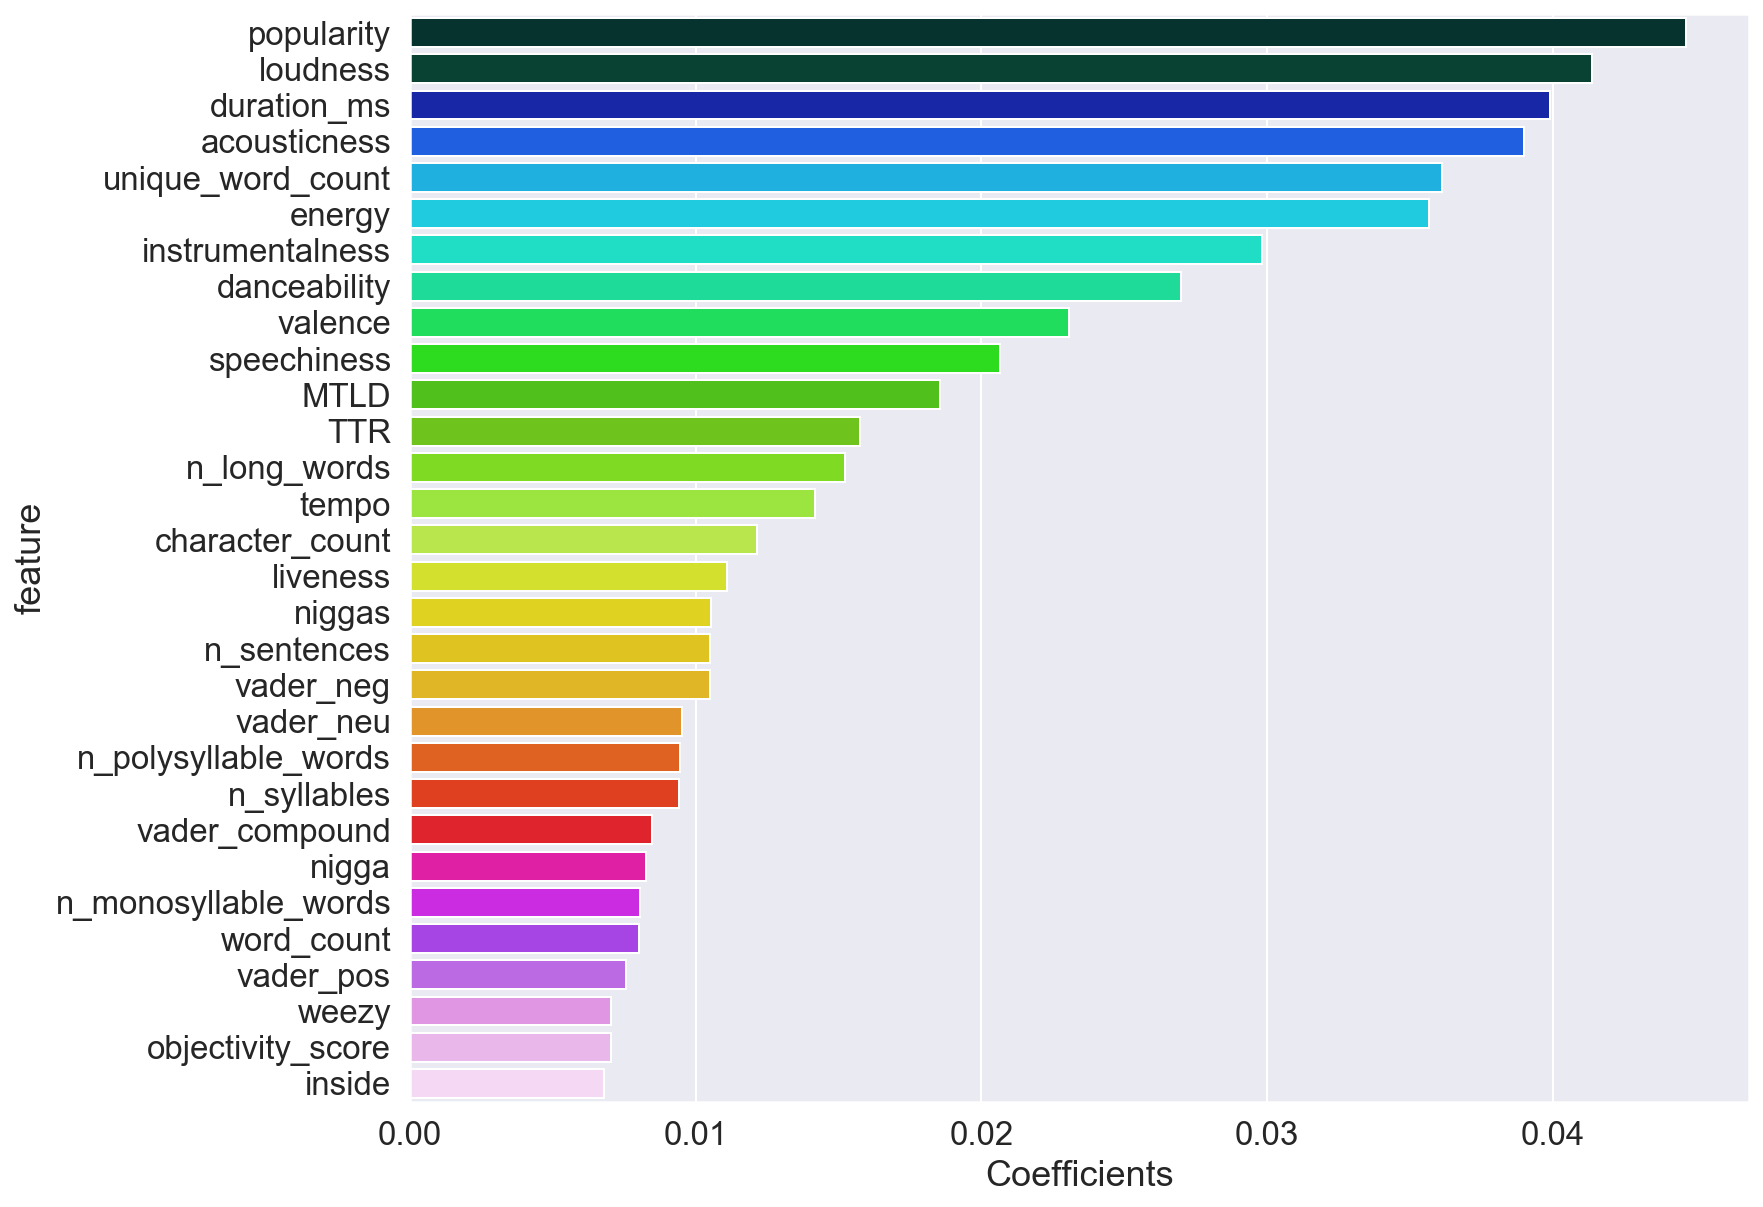

In [35]:
fig, ax = plt.subplots(figsize=(12,10))
sns.barplot(data=feature_sorted, y='feature', x='importance', orient='h', palette='gist_ncar')
ax.set_yticklabels(labels=feature_sorted.feature);
ax.set(xlabel='Coefficients');


* **Reduced features to 750 according to their importance.**

In [36]:
features_list = []
for i in feature_import.sort_values('importance', ascending=False)[:750].feature:
    features_list.append(i)

In [37]:
X_train_750 = X_train_t[features_list]

In [38]:
X_test_750 = X_test_t[features_list]

In [39]:
random_forest = RandomForestClassifier(random_state=42)

In [40]:
params = {'class_weight':['balanced'],
         'n_estimators':[500],
         'criterion': ['gini'],
         'max_depth': [20, 50, 100]+[None],
         'max_features': [None, 10, 100, 200, 300, 500]}

In [41]:
random_grid = GridSearchCV(random_forest,
                           param_grid=params,
                           scoring='accuracy',
                           cv=5,
                           n_jobs=2,
                           verbose=1,
                           iid=False)
random_grid.fit(X_train_750, y_train_t)
random_grid.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  6.0min
[Parallel(n_jobs=2)]: Done 120 out of 120 | elapsed: 16.8min finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=50, max_features=100,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [42]:
best_750 = random_grid.best_estimator_

In [43]:
print()
print('Cross validation score:  ' , cross_val_score(best_750, X_train_750, y_train, cv=5).mean())
print()
print('Training accuracy score:  ', best_750.score(X_train_750, y_train_t))
print()
print('Testing accuracy score:  ', best_750.score(X_test_750, y_test_t))


Cross validation score:   0.4575334588296224

Training accuracy score:   1.0

Testing accuracy score:   0.467680608365019


* **Reduced features to 500 according to their importance.**

In [44]:
features_list = []
for i in feature_import.sort_values('importance', ascending=False)[:500].feature:
    features_list.append(i)

In [45]:
X_train_500 = X_train_t[features_list]

In [46]:
X_test_500 = X_test_t[features_list]

In [47]:
random_forest = RandomForestClassifier(random_state=42)

In [48]:
params = {'class_weight':['balanced'],
         'n_estimators':[500],
         'criterion': ['gini'],
         'max_depth': [25, 50, 100]+[None],
         'max_features': [None, 100, 200, 300]}

In [49]:
random_grid = GridSearchCV(random_forest, param_grid=params, cv=5, n_jobs=2, verbose=1, iid=False)
random_grid.fit(X_train_500, y_train_t)
random_grid.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  6.9min
[Parallel(n_jobs=2)]: Done  80 out of  80 | elapsed: 11.5min finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=100, max_features=100,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [50]:
best_500 = random_grid.best_estimator_

In [51]:
print()
print('Cross validation score:  ' , cross_val_score(best_500, X_train_500, y_train_t, cv=5).mean())
print()
print('Training accuracy score:  ', best_500.score(X_train_500, y_train_t))
print()
print('Testing accuracy score:  ', best_500.score(X_test_500, y_test_t))


Cross validation score:   0.45858054985215757

Training accuracy score:   1.0

Testing accuracy score:   0.4600760456273764


* **Reduced features to 250 according to their importance.**

In [52]:
features_list = []
for i in feature_import.sort_values('importance', ascending=False)[:250].feature:
    features_list.append(i)

In [53]:
X_train_250 = X_train_t[features_list]

In [54]:
X_test_250 = X_test_t[features_list]

In [55]:
random_forest = RandomForestClassifier(random_state=42)

In [56]:
params = {'class_weight':['balanced'],
         'n_estimators':[500],
         'criterion': ['gini'],
         'max_depth': [25, 50, 100]+[None],
         'max_features': [None, 100, 200]}

In [57]:
random_grid = GridSearchCV(random_forest, param_grid=params, cv=5, n_jobs=2, verbose=1, iid=False)
random_grid.fit(X_train_250, y_train_t)
random_grid.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  6.5min
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:  8.5min finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=50, max_features=200,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [58]:
best_250 = random_grid.best_estimator_

In [59]:
print()
print('Cross validation score:  ' , cross_val_score(best_250, X_train_250, y_train_t, cv=5).mean())
print()
print('Training accuracy score:  ', best_250.score(X_train_250, y_train_t))
print()
print('Testing accuracy score:  ', best_250.score(X_test_250, y_test_t))


Cross validation score:   0.4544869620748894

Training accuracy score:   1.0

Testing accuracy score:   0.4524714828897338


## Model Evaluation

* Defined predicted y_train and y_test.

In [60]:
predict_train = best_500.predict(X_train_500)
predict_test = best_500.predict(X_test_500)

* Computed the confusion matrix.

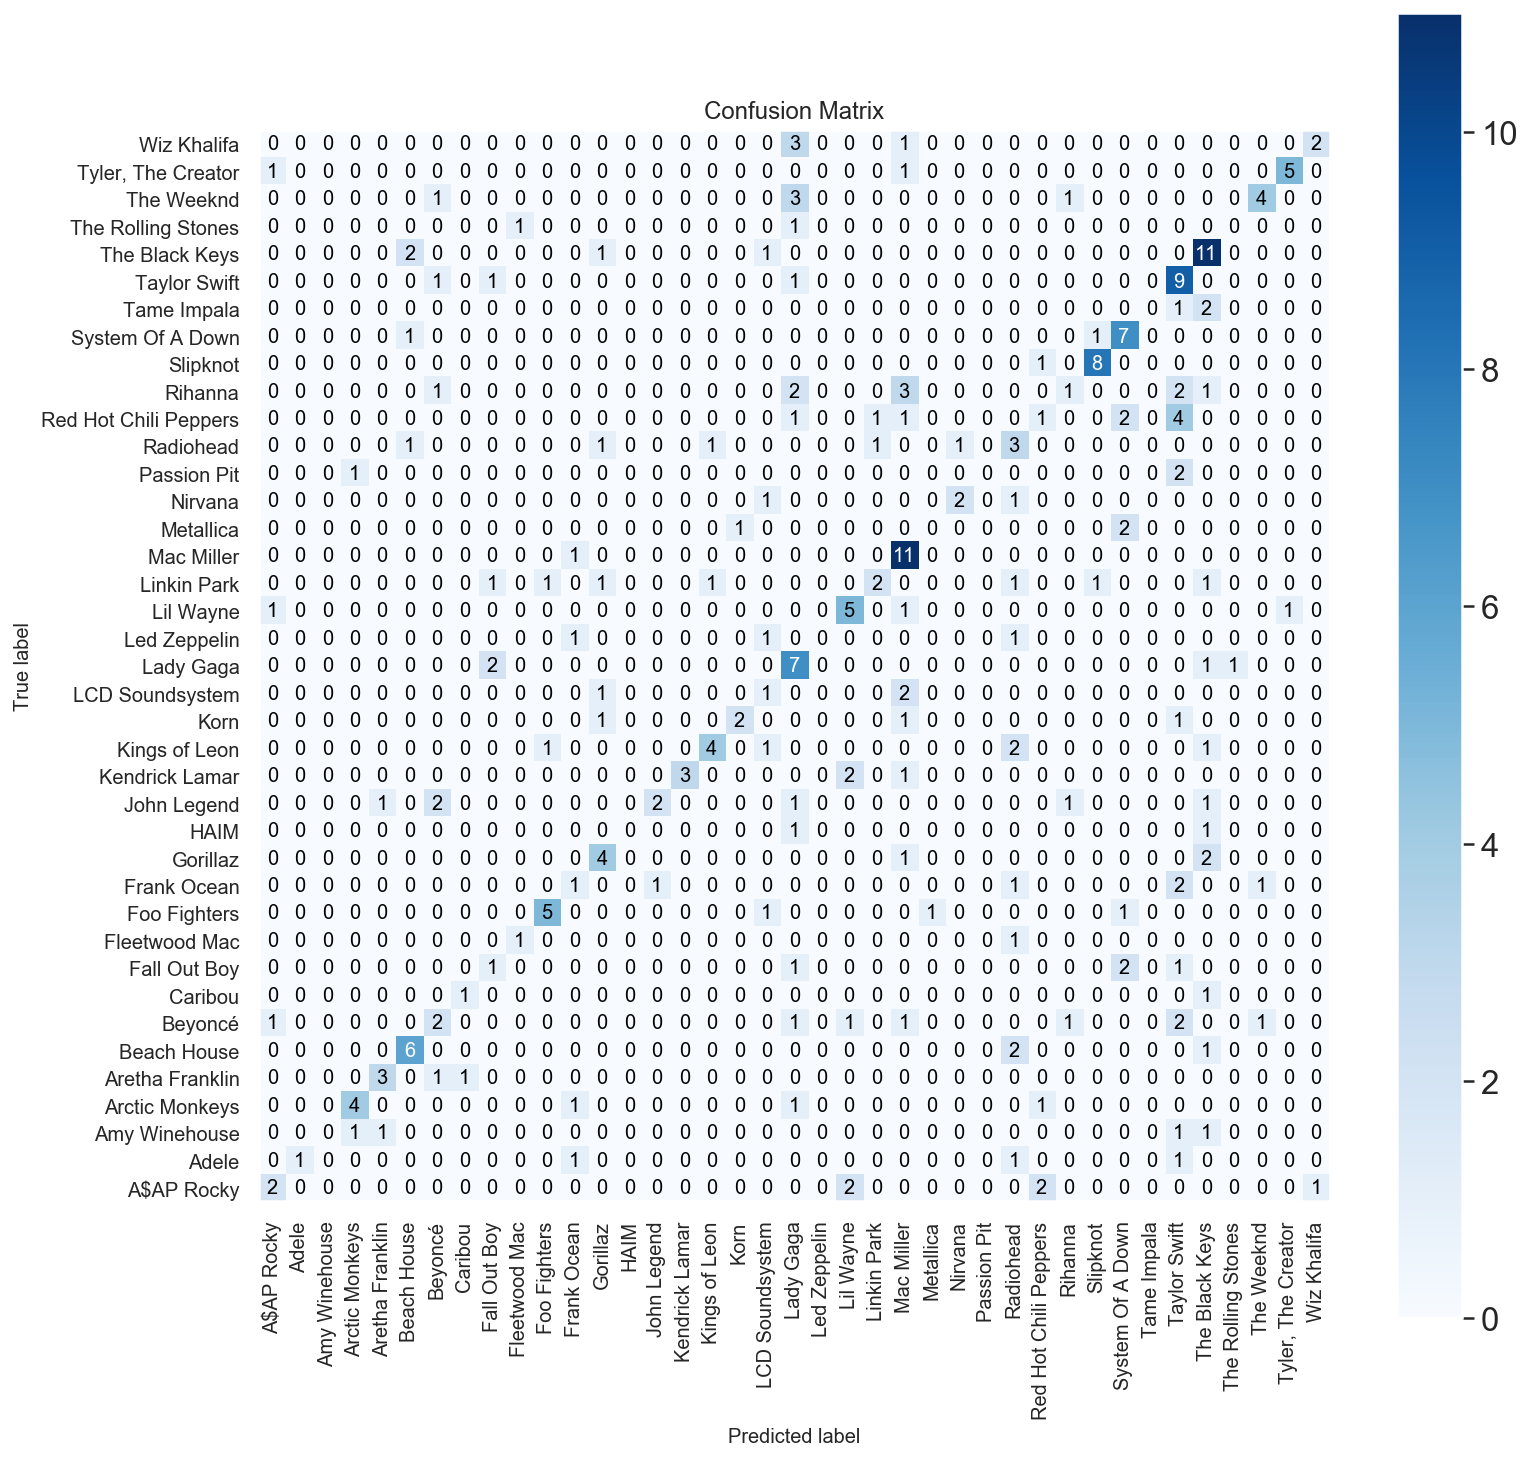

In [61]:
cmap = ListedColormap(sns.color_palette("husl", len(best_500.classes_)))
skplt.metrics.plot_confusion_matrix(y_test_t, predict_test, figsize=(12,12))
plt.ylim([-0.5, len(y_test_t.unique())-0.5])
plt.xticks(rotation=90)
plt.show()

* Computed the classification report.

In [62]:
print(classification_report(y_test_t, predict_test))

                       precision    recall  f1-score   support

           A$AP Rocky       0.40      0.29      0.33         7
                Adele       1.00      0.25      0.40         4
        Amy Winehouse       0.00      0.00      0.00         4
       Arctic Monkeys       0.67      0.57      0.62         7
      Aretha Franklin       0.60      0.60      0.60         5
          Beach House       0.60      0.67      0.63         9
              Beyoncé       0.25      0.20      0.22        10
              Caribou       0.50      0.50      0.50         2
         Fall Out Boy       0.20      0.20      0.20         5
        Fleetwood Mac       0.50      0.50      0.50         2
         Foo Fighters       0.71      0.62      0.67         8
          Frank Ocean       0.20      0.17      0.18         6
             Gorillaz       0.44      0.57      0.50         7
                 HAIM       0.00      0.00      0.00         2
          John Legend       0.67      0.25      0.36  

* Investigated the relationship between songs per artist and the model's precision, recall and F1 score predicting their class.

In [63]:
data = pd.read_csv('/Users/constancemaurer/GA DSI 12/DSI12-lessons/projects/project-capstone/personal-github/Resources/Model_data.csv')

In [64]:
classification_report_table = data.groupby('artist_name').count()[['track_name']]
classification_report_table.reset_index(inplace=True)

In [65]:
precision, recall, f1, support = precision_recall_fscore_support(y_test_t, predict_test, average=None)

In [66]:
classification_report_table['precision_score'] = precision
classification_report_table['recall_score'] = recall
classification_report_table['f1_score'] = f1
classification_report_table['n_samples_test_set'] = support
classification_report_table

artist_name  track_name  precision_score  recall_score  \
0              A$AP Rocky          33         0.400000      0.285714   
1                   Adele          23         1.000000      0.250000   
2           Amy Winehouse          19         0.000000      0.000000   
3          Arctic Monkeys          36         0.666667      0.571429   
4         Aretha Franklin          23         0.600000      0.600000   
5             Beach House          43         0.600000      0.666667   
6                 Beyoncé          48         0.250000      0.200000   
7                 Caribou          11         0.500000      0.500000   
8            Fall Out Boy          26         0.200000      0.200000   
9           Fleetwood Mac          12         0.500000      0.500000   
10           Foo Fighters          38         0.714286      0.625000   
11            Frank Ocean          29         0.200000      0.166667   
12               Gorillaz          36         0.444444      0.571429   
13                   HAIM          10         0.000000      0.000000   
14            John Legend          40         0.666667      0.250000   
15         Kendrick Lamar          30         1.000000      0.500000   
16          Kings of Leon          43         0.666667      0.444444   
17                   Korn          24         0.666667      0.400000   
18        LCD Soundsystem          22         0.166667      0.250000   
19              Lady Gaga          54         0.304348      0.636364   
20           Led Zeppelin          15         0.000000      0.000000   
21              Lil Wayne          40         0.500000      0.625000   
22            Linkin Park          43         0.500000      0.222222   
23             Mac Miller          58         0.458333      0.916667   
24              Metallica          16         0.000000      0.000000   
25                Nirvana          21         0.666667      0.500000   
26            Passion Pit          16         0.000000      0.000000   
27              Radiohead          41         0.230769      0.375000   
28  Red Hot Chili Peppers          52         0.200000      0.100000   
29                Rihanna          48         0.250000      0.100000   
30               Slipknot          47         0.800000      0.888889   
31       System Of A Down          45         0.500000      0.777778   
32            Tame Impala          17         0.000000      0.000000   
33           Taylor Swift          58         0.346154      0.750000   
34         The Black Keys          76         0.458333      0.733333   
35     The Rolling Stones          10         0.000000      0.000000   
36             The Weeknd          47         0.666667      0.444444   
37     Tyler, The Creator          33         0.833333      0.714286   
38            Wiz Khalifa          29         0.666667      0.333333   

    f1_score  n_samples_test_set  
0   0.333333                   7  
1   0.400000                   4  
2   0.000000                   4  
3   0.615385                   7  
4   0.600000                   5  
5   0.631579                   9  
6   0.222222                  10  
7   0.500000                   2  
8   0.200000                   5  
9   0.500000                   2  
10  0.666667                   8  
11  0.181818                   6  
12  0.500000                   7  
13  0.000000                   2  
14  0.363636                   8  
15  0.666667                   6  
16  0.533333                   9  
17  0.500000                   5  
18  0.200000                   4  
19  0.411765                  11  
20  0.000000                   3  
21  0.555556                   8  
22  0.307692                   9  
23  0.611111                  12  
24  0.000000                   3  
25  0.571429                   4  
26  0.000000                   3  
27  0.285714                   8  
28  0.133333                  10  
29  0.142857                  10  
30  0.842105                   9  
31  0.608696 

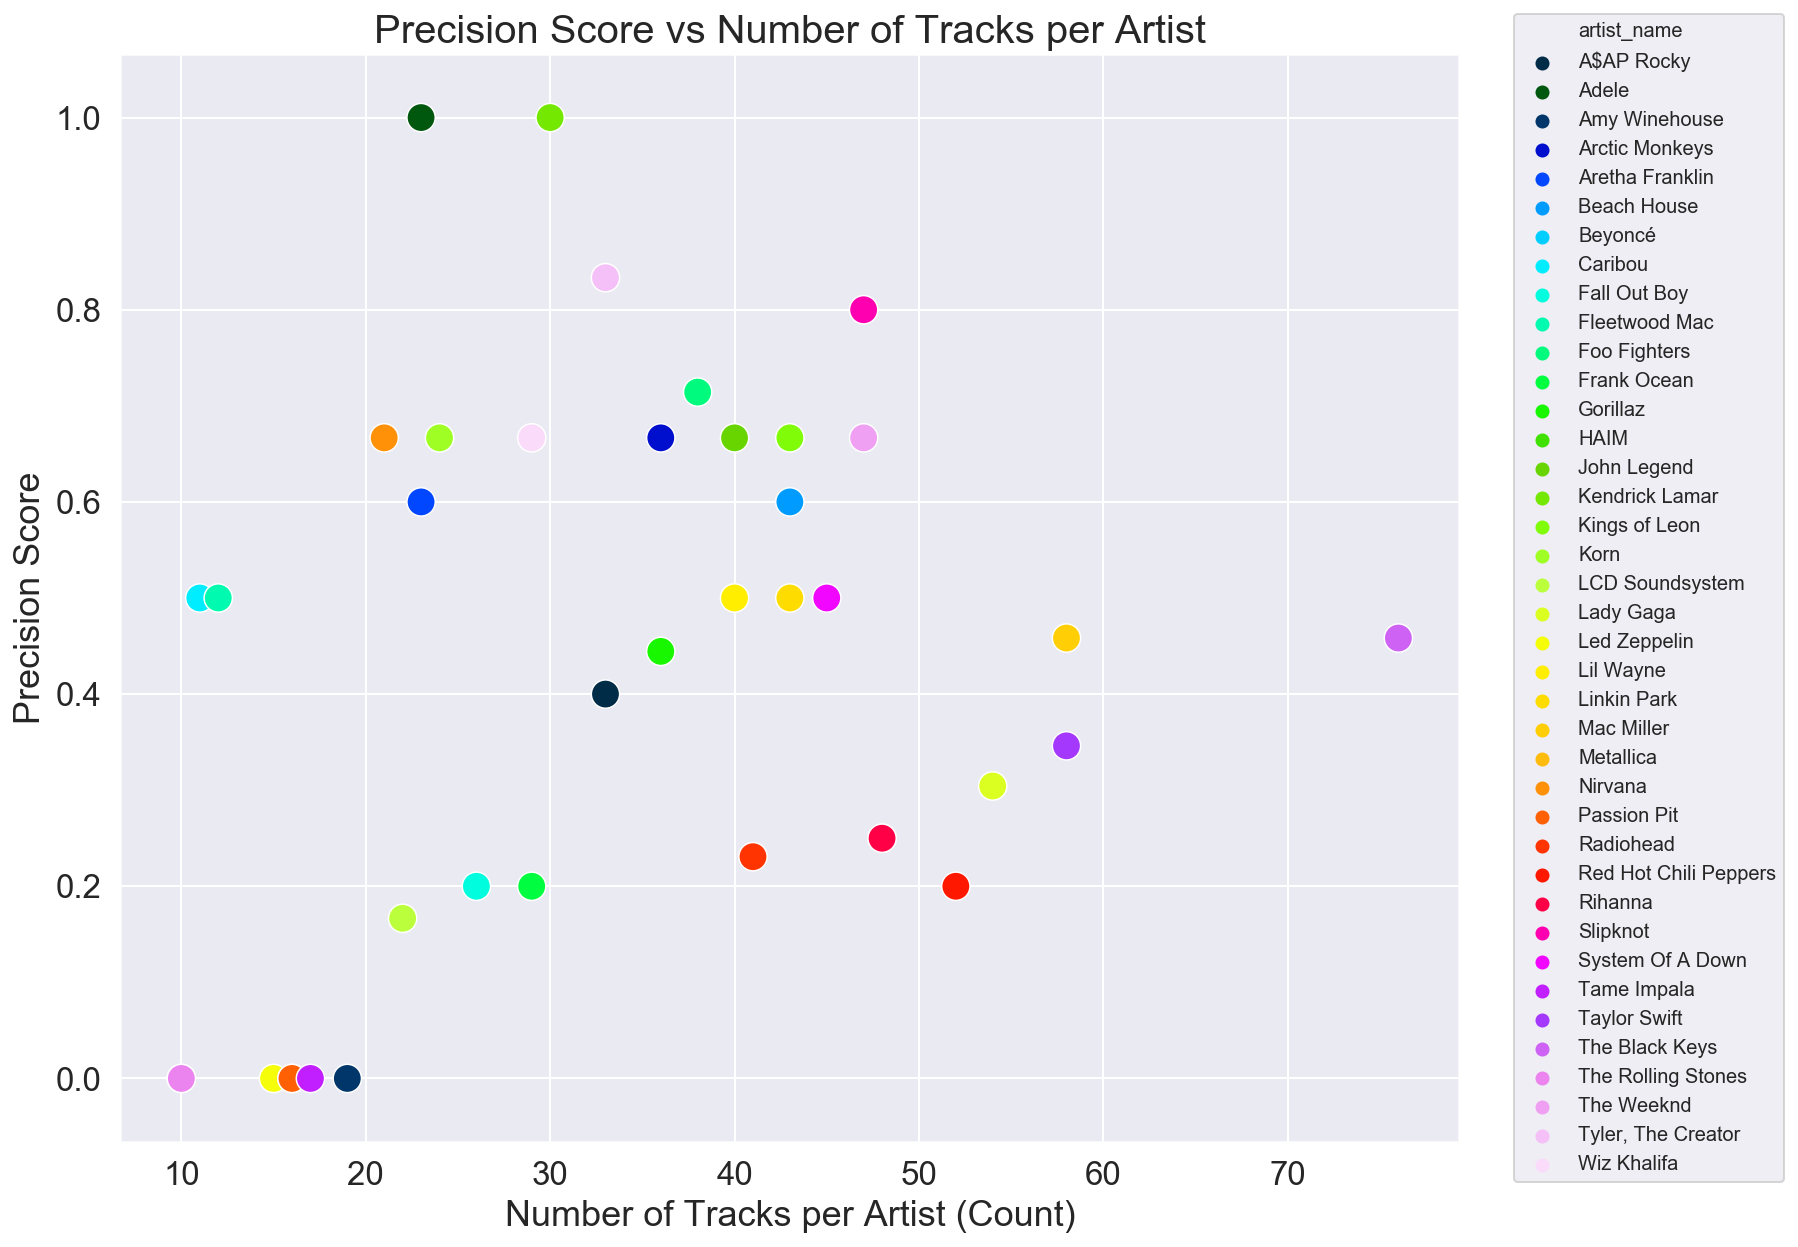

In [67]:
fig, ax = plt.subplots(figsize=(12,10))
sns.scatterplot(data=classification_report_table, x='track_name', y='precision_score', hue='artist_name', s=200, palette='gist_ncar');
#sns.scatterplot(data=artist_count, x='track_name', y='recall_score', hue='artist_name', palette='Blues');
#sns.scatterplot(data=artist_count, x='track_name', y='f1_score', hue='artist_name', palette='Greens');
ax.set_xlabel('Number of Tracks per Artist (Count)');
ax.set_ylabel('Precision Score');
plt.title("Precision Score vs Number of Tracks per Artist", size=20)
ax.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1, fontsize='medium')
plt.show()

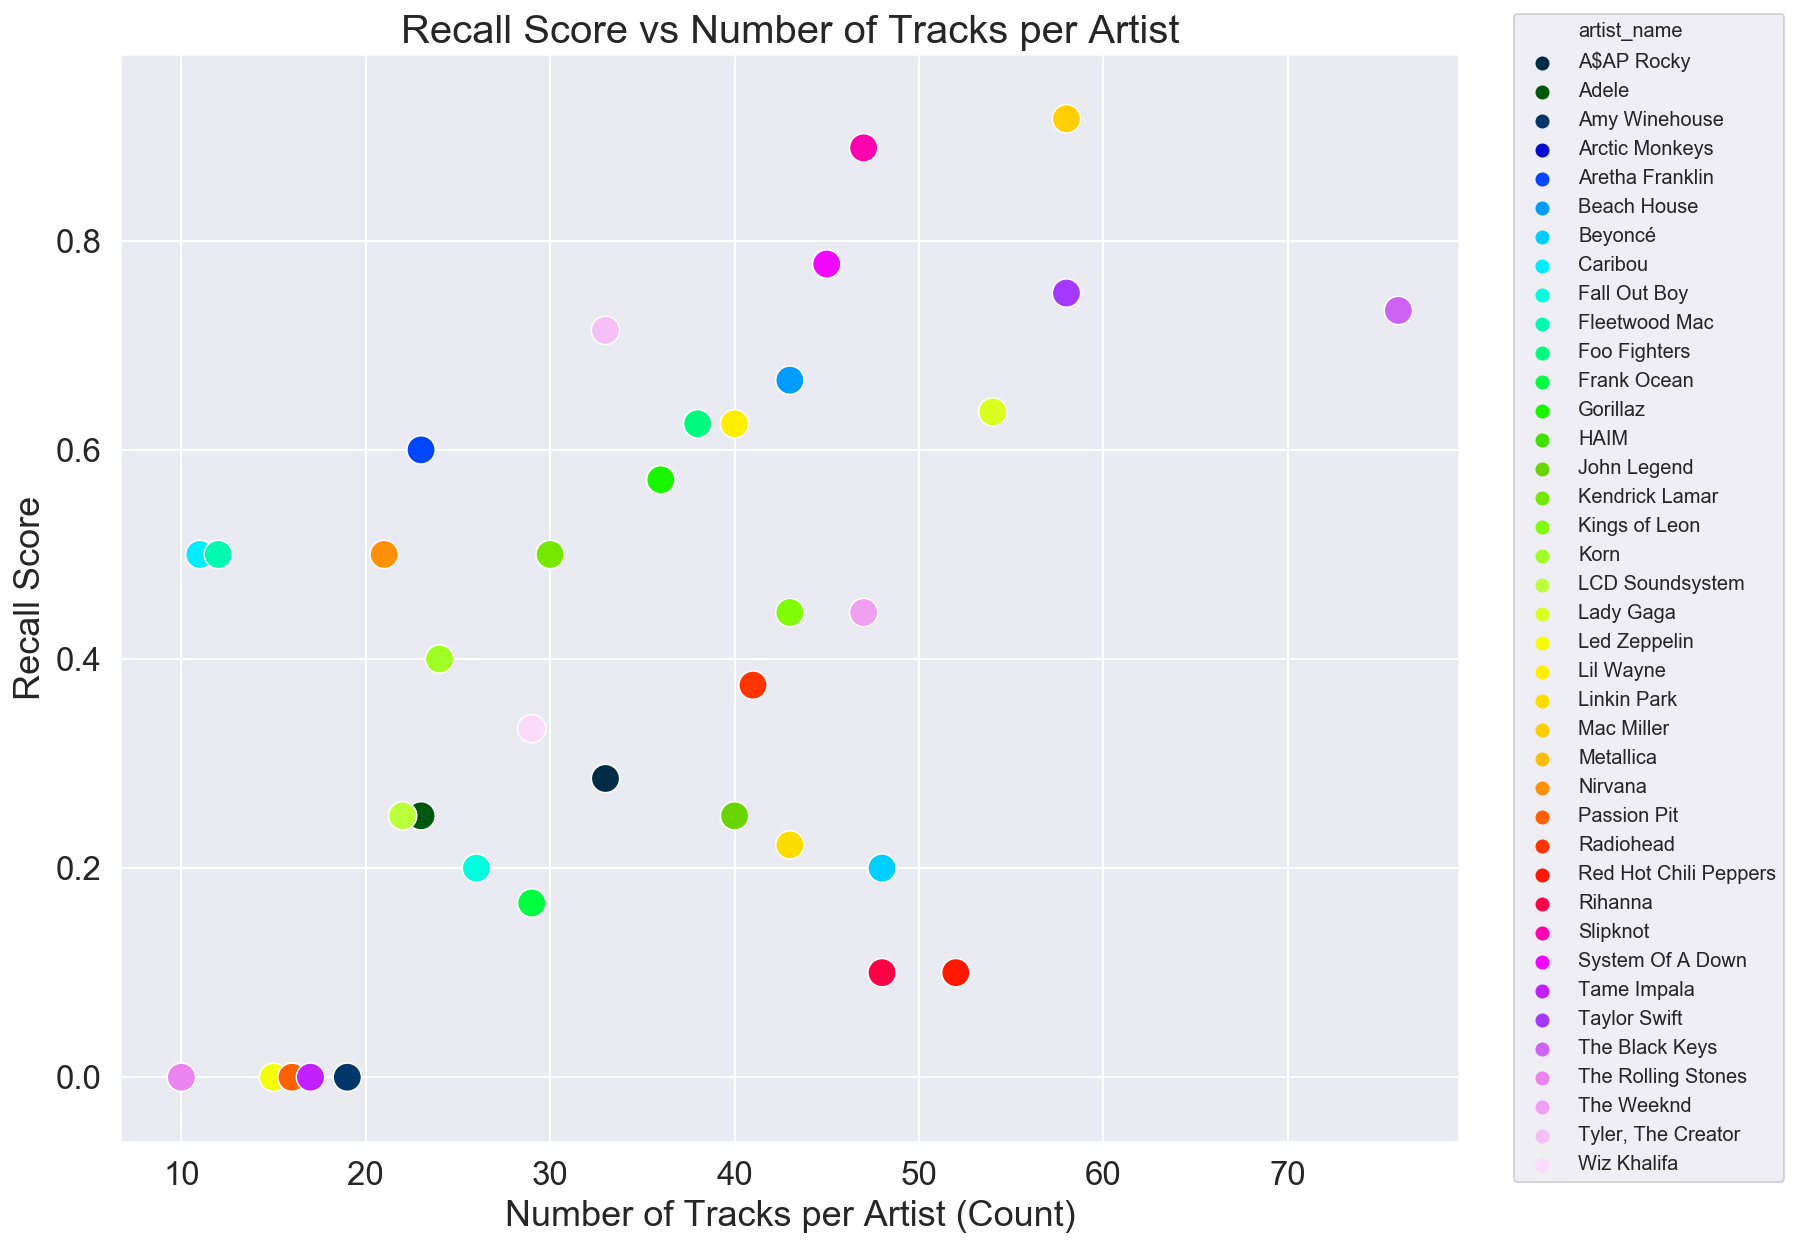

In [68]:
fig, ax = plt.subplots(figsize=(12,10))
#sns.scatterplot(data=artist_count, x='track_name', y='precision_score', hue='artist_name', palette='Reds');
sns.scatterplot(data=classification_report_table, x='track_name', y='recall_score', hue='artist_name', s=200, palette='gist_ncar');
#sns.scatterplot(data=artist_count, x='track_name', y='f1_score', hue='artist_name', palette='Greens');
ax.set_xlabel('Number of Tracks per Artist (Count)');
ax.set_ylabel('Recall Score');
plt.title("Recall Score vs Number of Tracks per Artist", size=20)
ax.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1, fontsize='medium')
plt.show()

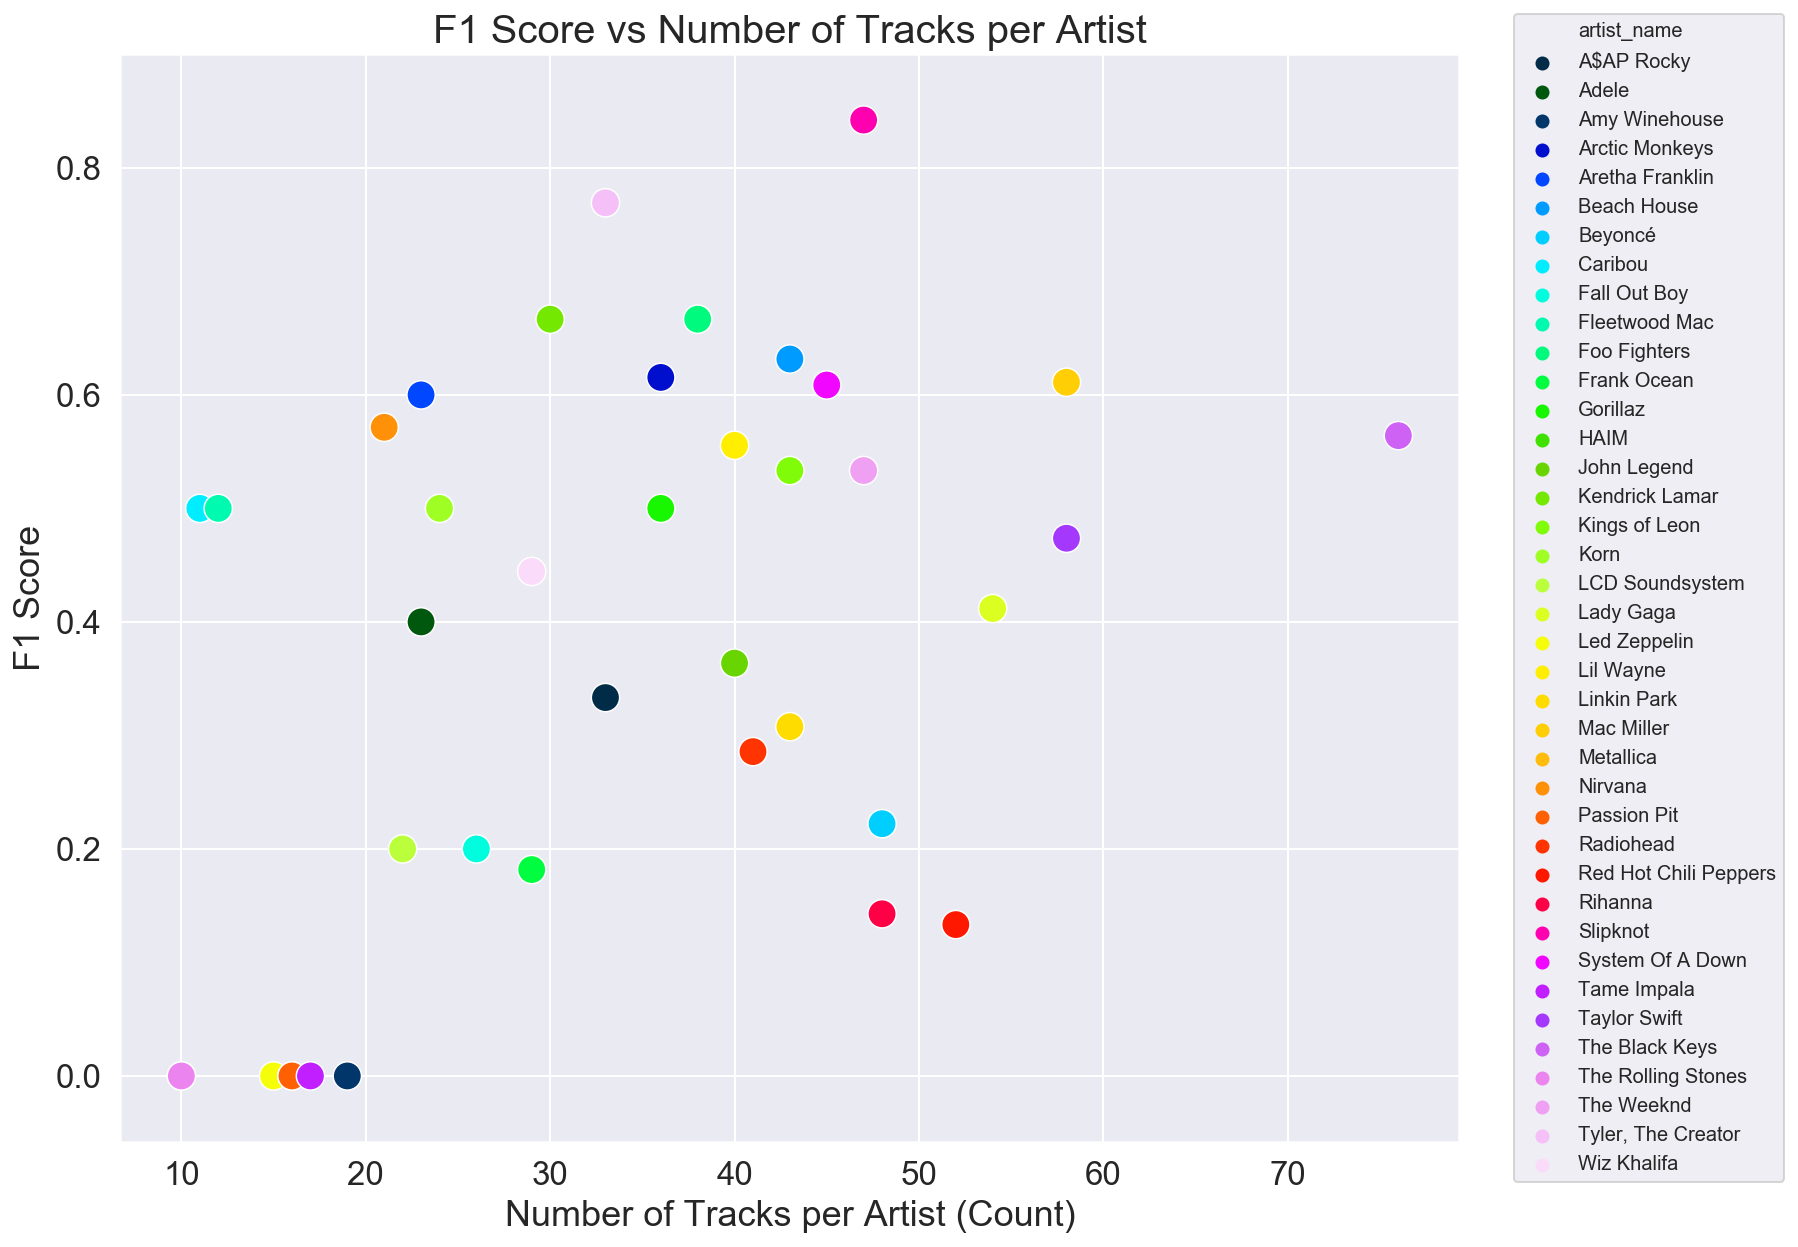

In [69]:
fig, ax = plt.subplots(figsize=(12,10))
#sns.scatterplot(data=classification_report_table, x='track_name', y='precision_score', hue='artist_name', palette='Reds');
#sns.scatterplot(data=classification_report_table, x='track_name', y='recall_score', hue='artist_name', palette='gist_ncar');
sns.scatterplot(data=classification_report_table, x='track_name', y='f1_score', hue='artist_name', s=200, palette='gist_ncar');
ax.set_xlabel('Number of Tracks per Artist (Count)');
ax.set_ylabel('F1 Score');
plt.title("F1 Score vs Number of Tracks per Artist", size=20)
ax.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1, fontsize='medium')
plt.show()

**Alternative Confusion Matrix**

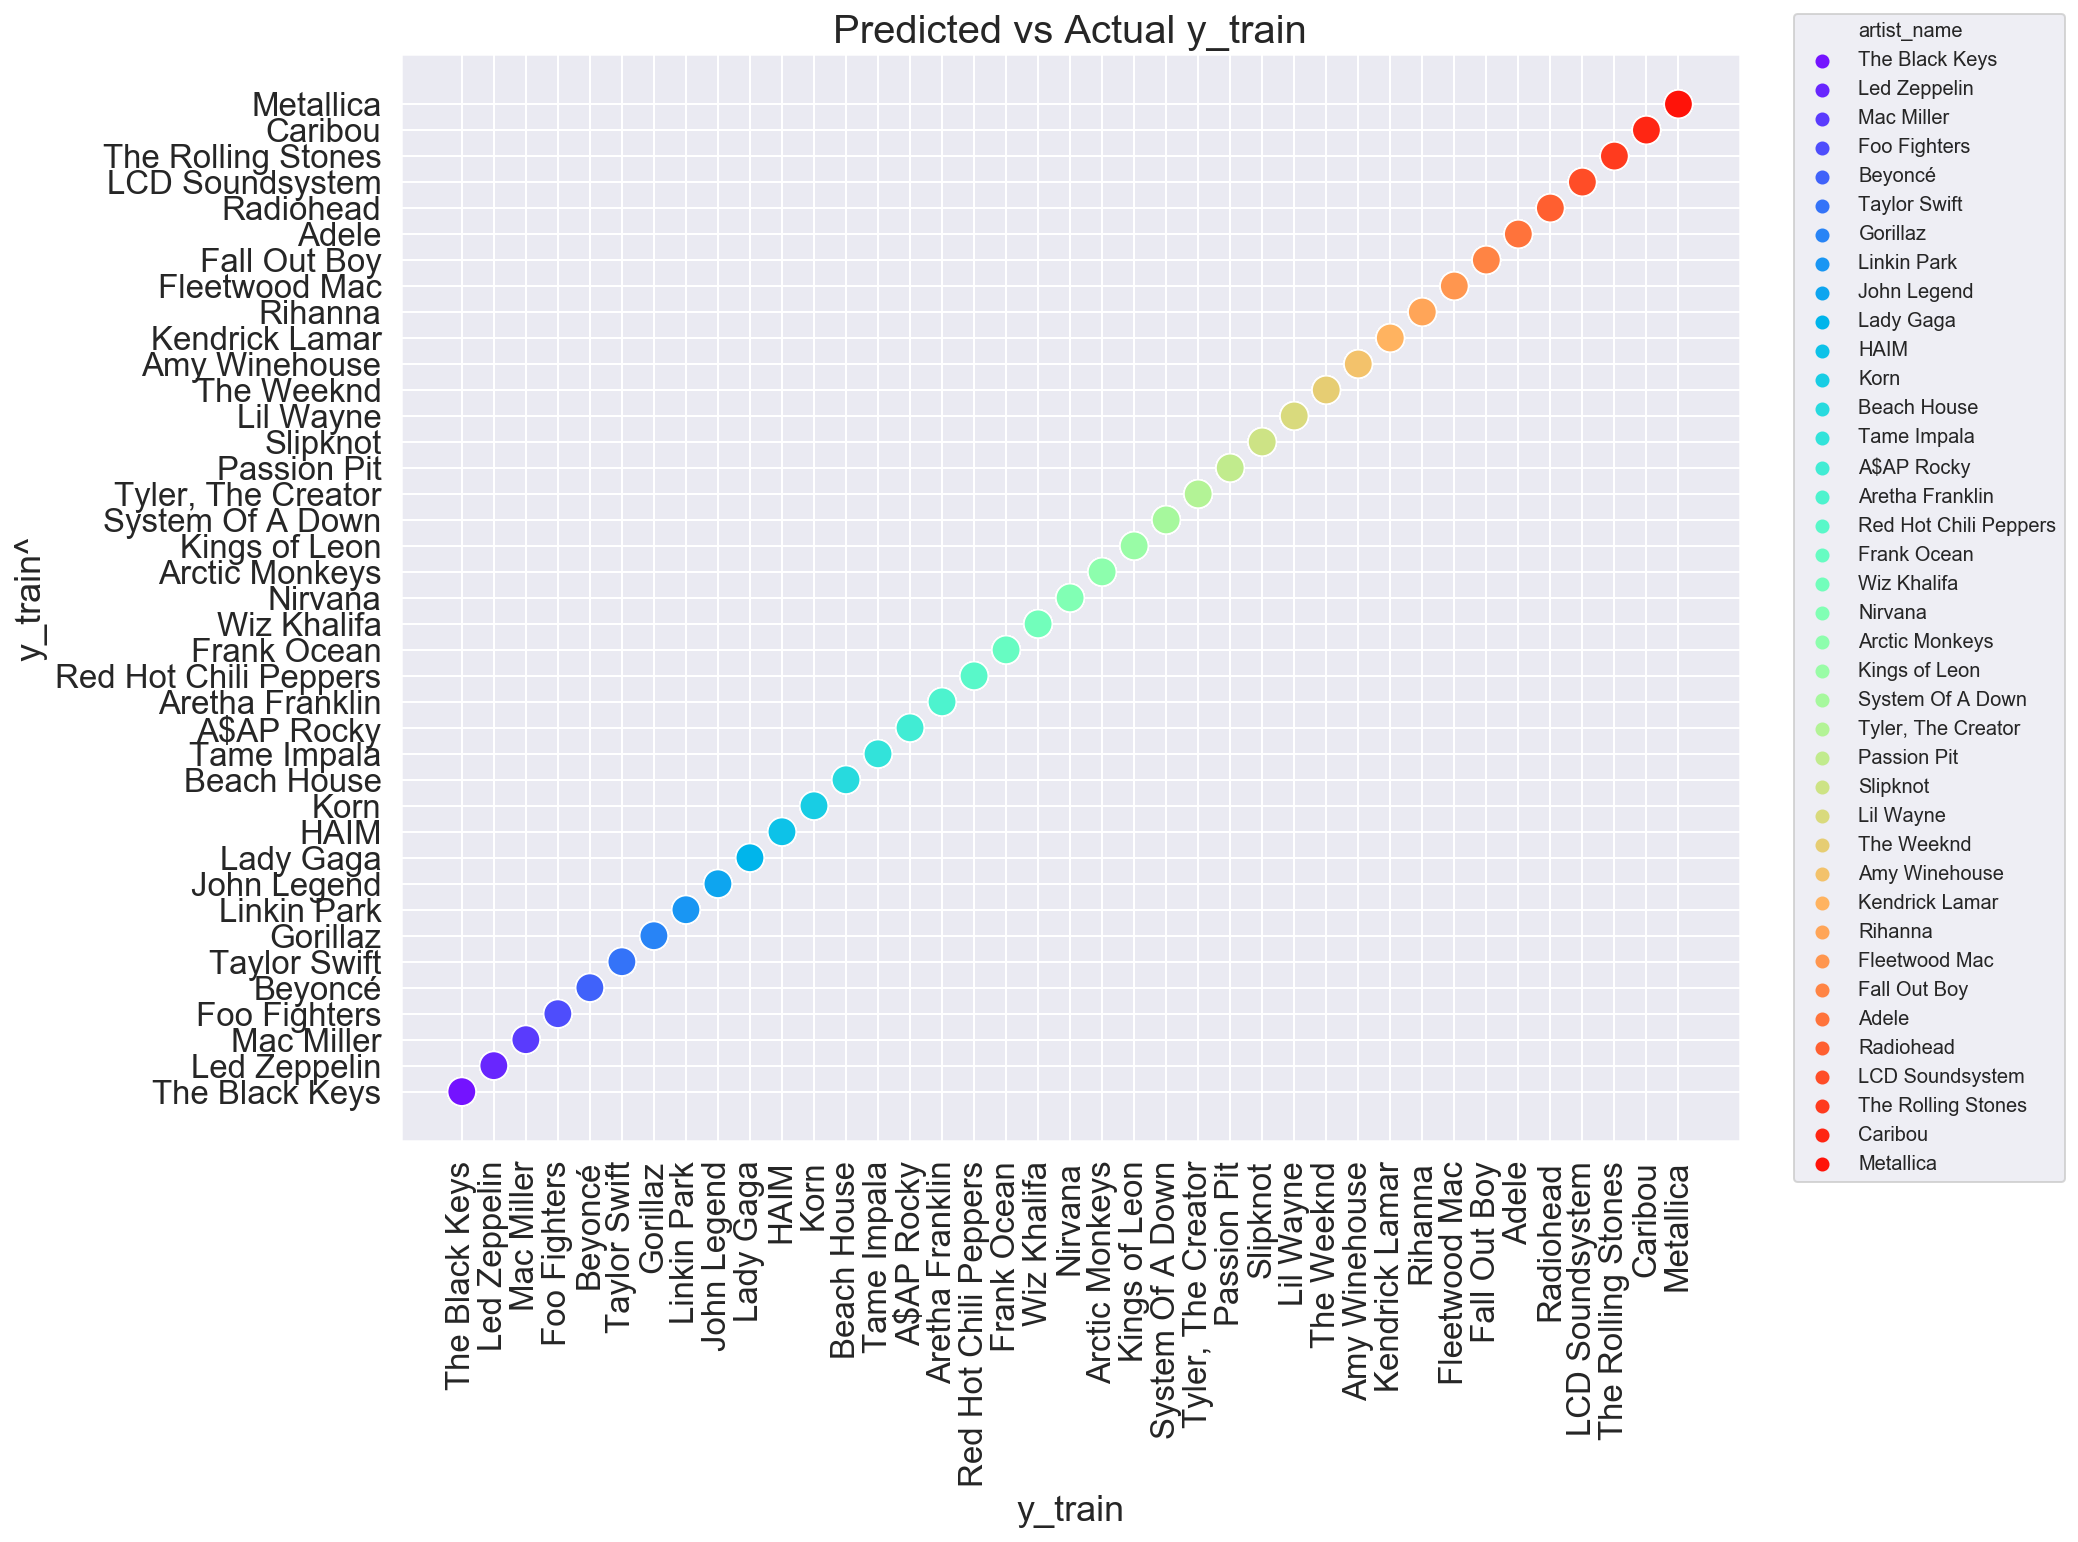

In [70]:
fig, ax = plt.subplots(figsize=(12,10))
sns.scatterplot(x=y_train_t, y=predict_train, hue=y_train_t, s=200, palette='rainbow');
ax.set_xlabel('y_train');
ax.set_xticklabels(labels=y_train.unique(), rotation=90)
ax.set_ylabel('y_train^');
plt.title("Predicted vs Actual y_train", size=20)
ax.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1, fontsize='medium')
plt.show()

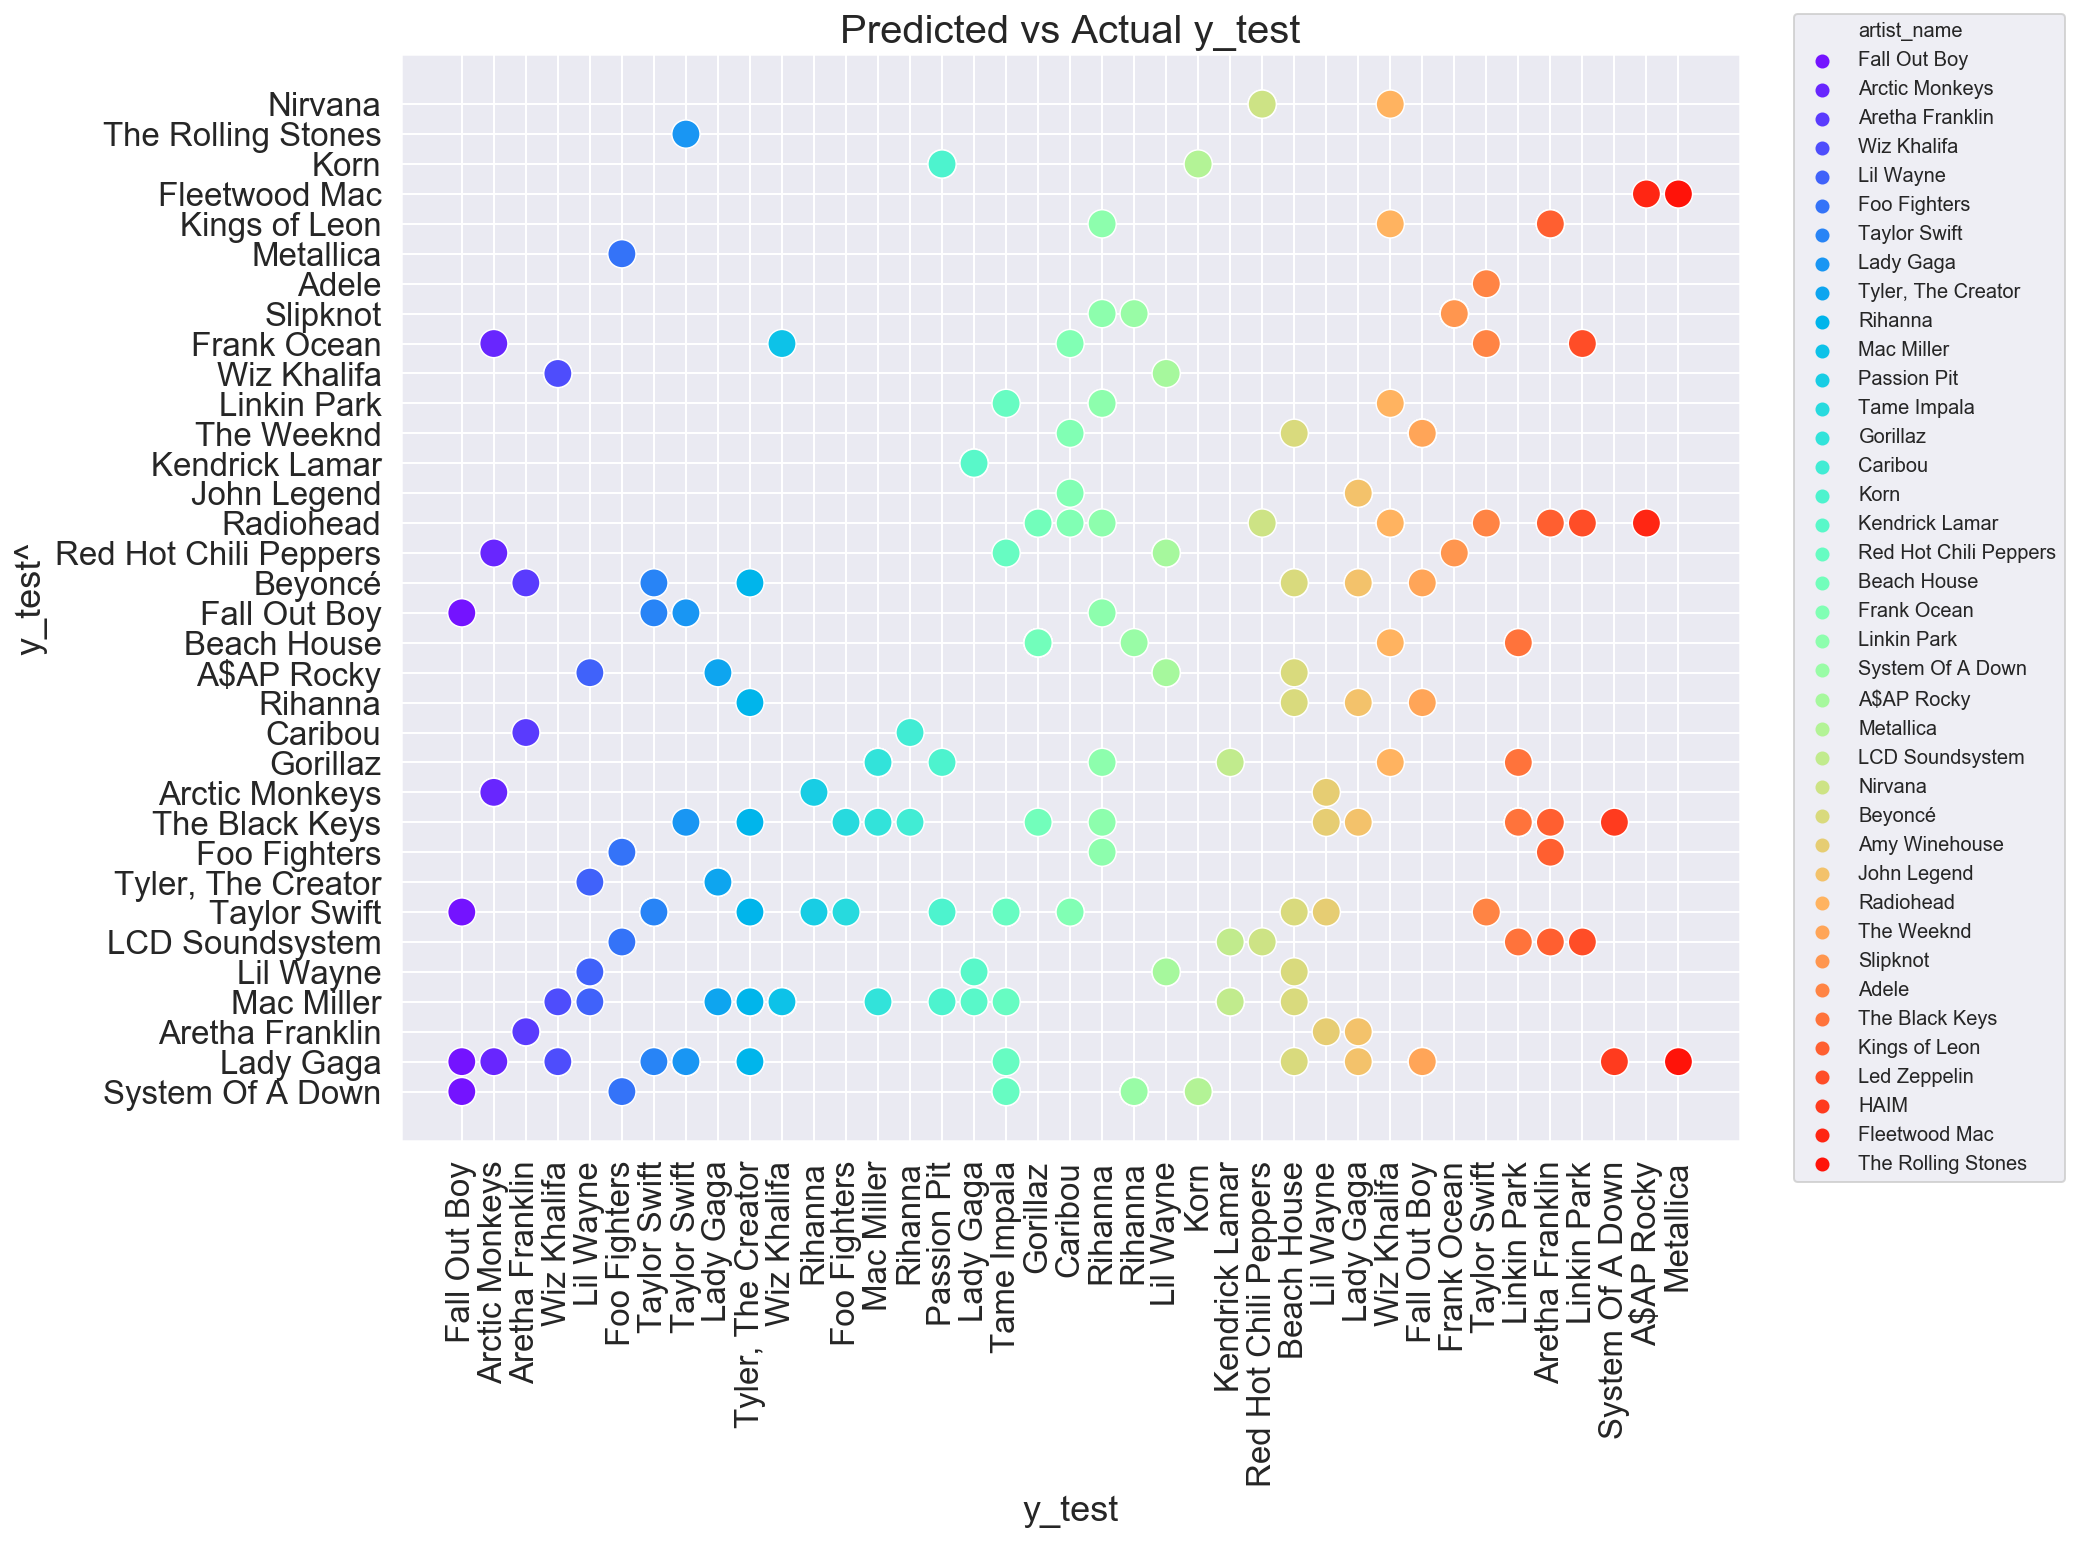

In [71]:
fig, ax = plt.subplots(figsize=(12,10))
sns.scatterplot(x=y_test_t, y=predict_test, hue=y_test_t, s=200, palette='rainbow');
ax.set_xlabel('y_test');
ax.set_xticklabels(labels=y_test_t, rotation=90)
#ax.set_yticklabels(labels=predict_test, rotation=0);
ax.set_ylabel('y_test^');
plt.title("Predicted vs Actual y_test", size=20)
ax.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1, fontsize='medium')
plt.show()

**ROC Curve**

* Computed ROC Curve by binarizing the classes with the label_binarize( ) function. This is neccessary for multi-label classification.

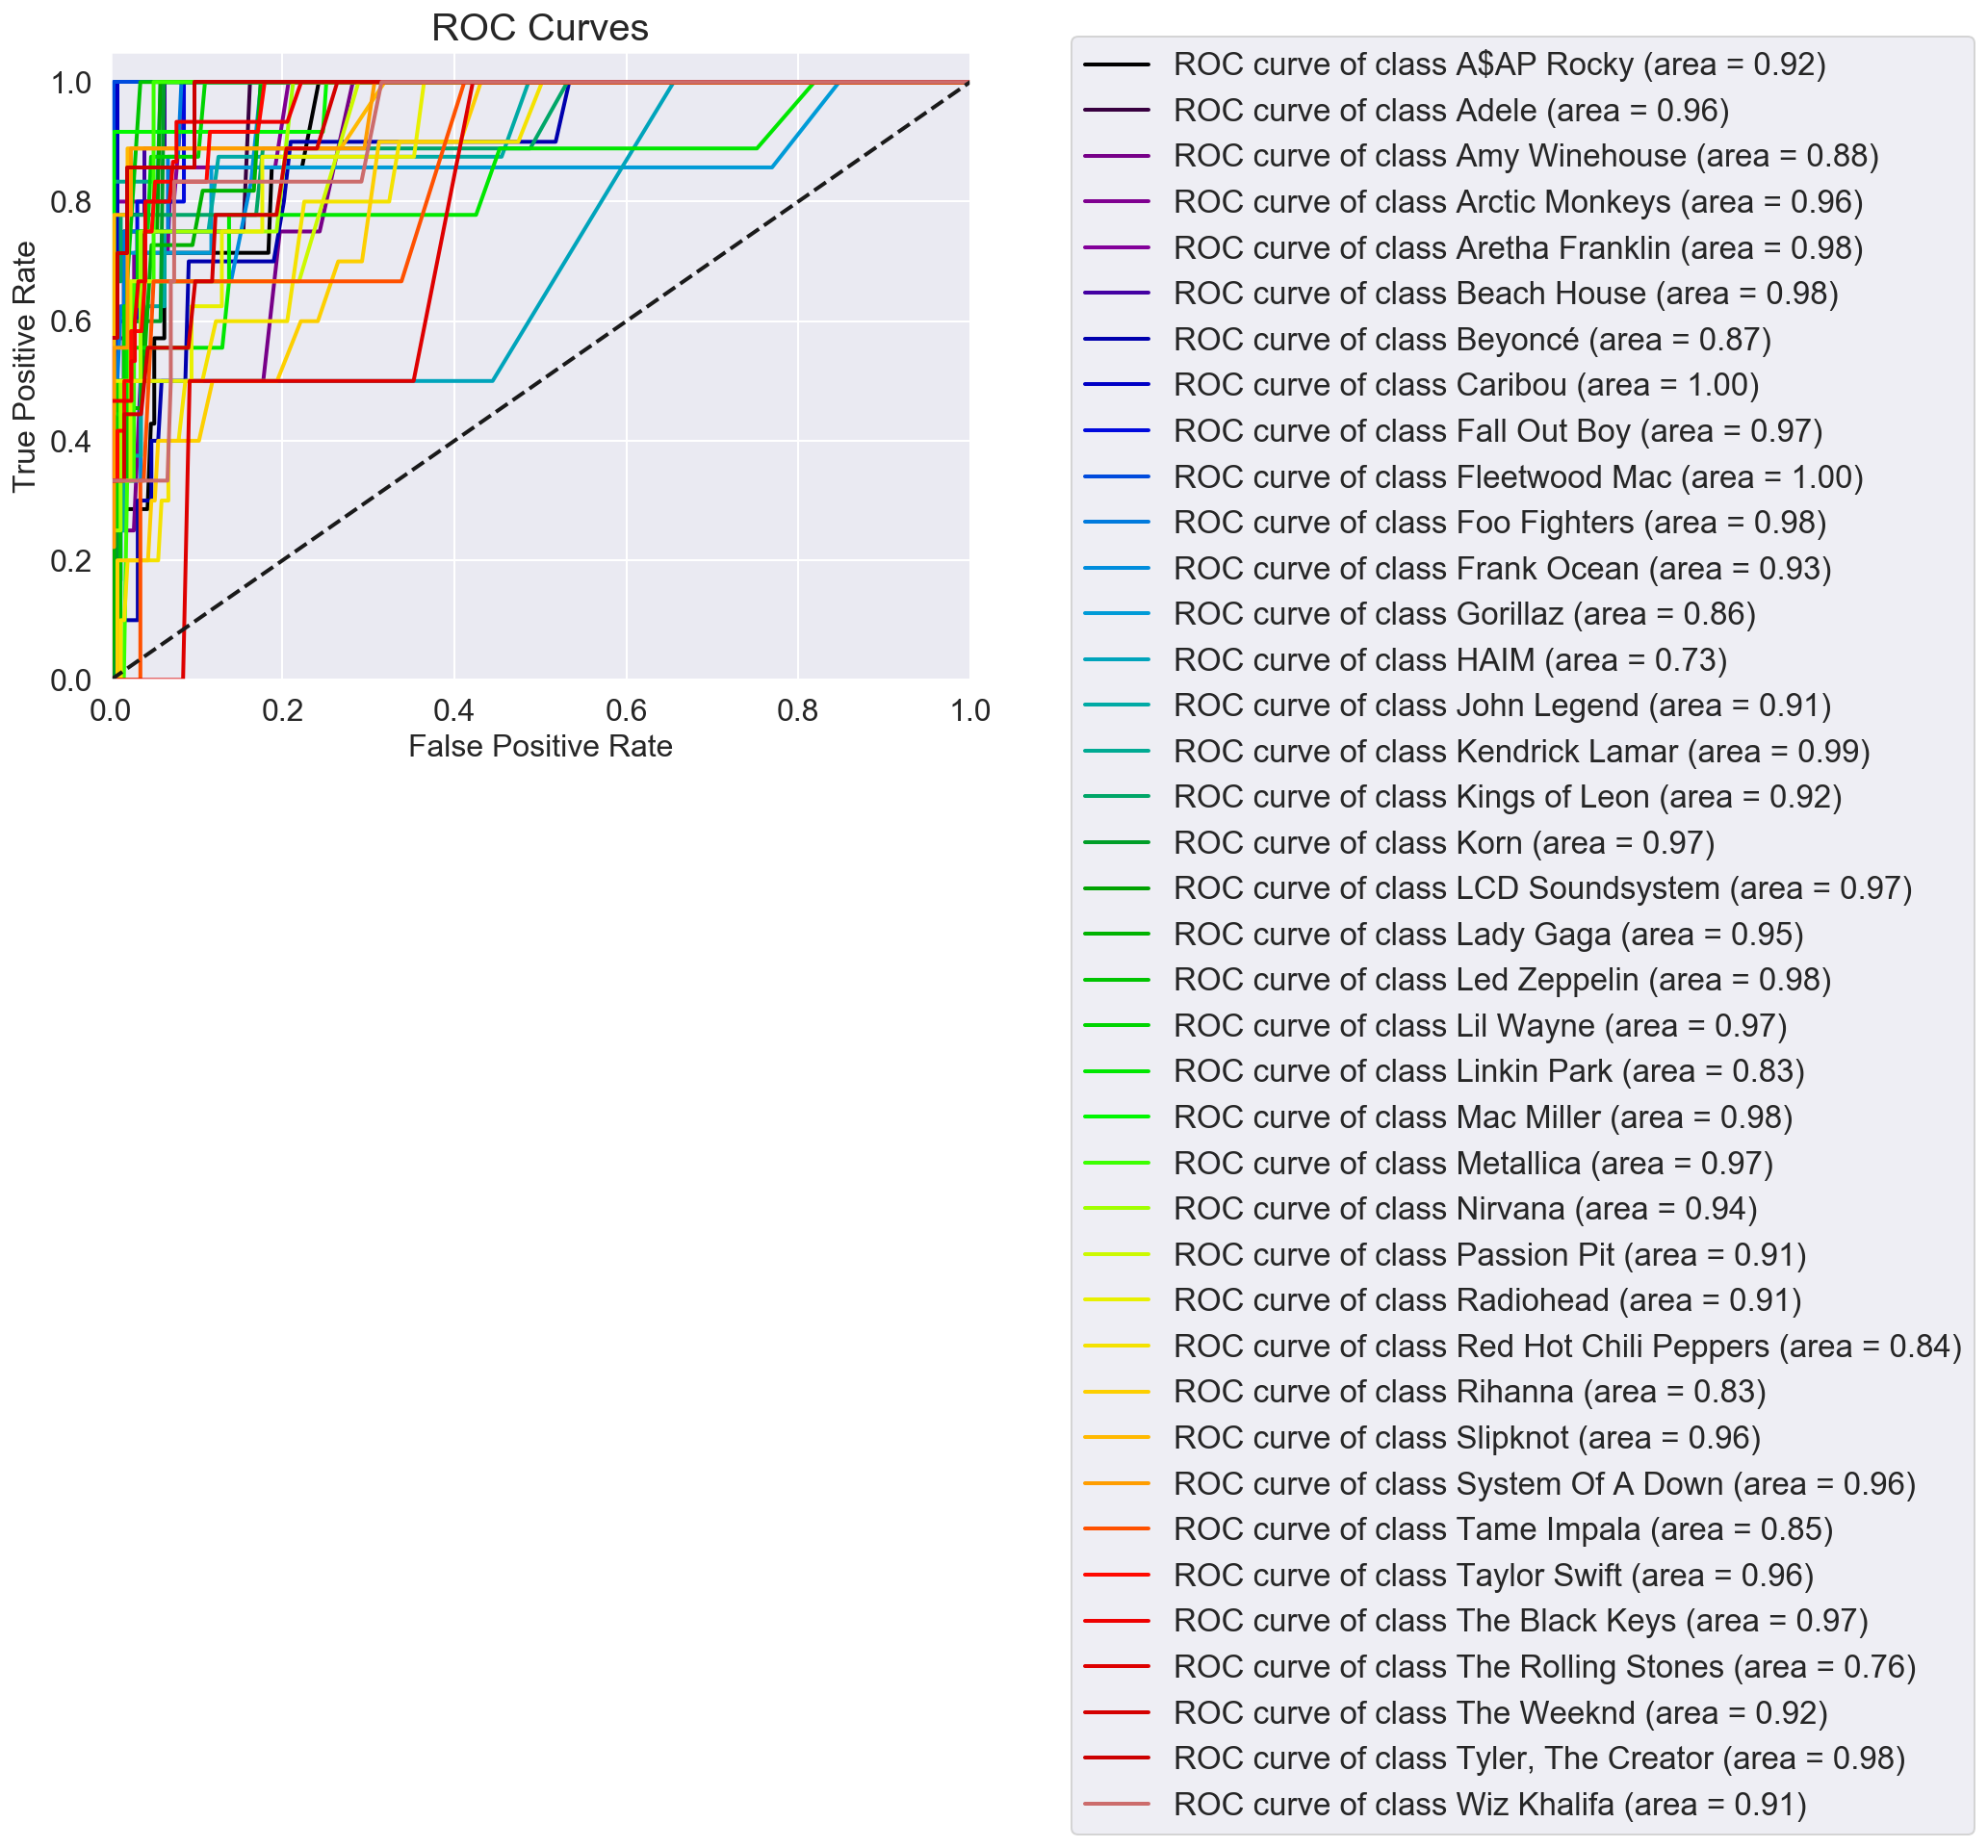

Area under ROC curve (ROC-AUC):
Class A$AP Rocky: 0.92
Class Adele: 0.96
Class Amy Winehouse: 0.88
Class Arctic Monkeys: 0.96
Class Aretha Franklin: 0.98
Class Beach House: 0.98
Class Beyoncé: 0.87
Class Caribou: 1.0
Class Fall Out Boy: 0.97
Class Fleetwood Mac: 1.0
Class Foo Fighters: 0.98
Class Frank Ocean: 0.93
Class Gorillaz: 0.86
Class HAIM: 0.73
Class John Legend: 0.91
Class Kendrick Lamar: 0.99
Class Kings of Leon: 0.92
Class Korn: 0.97
Class LCD Soundsystem: 0.97
Class Lady Gaga: 0.95
Class Led Zeppelin: 0.98
Class Lil Wayne: 0.97
Class Linkin Park: 0.83
Class Mac Miller: 0.98
Class Metallica: 0.97
Class Nirvana: 0.94
Class Passion Pit: 0.91
Class Radiohead: 0.91
Class Red Hot Chili Peppers: 0.84
Class Rihanna: 0.83
Class Slipknot: 0.96
Class System Of A Down: 0.96
Class Tame Impala: 0.85
Class Taylor Swift: 0.96
Class The Black Keys: 0.97
Class The Rolling Stones: 0.76
Class The Weeknd: 0.92
Class Tyler, The Creator: 0.98
Class Wiz Khalifa: 0.91


In [72]:
y_test_bin = label_binarize(y_test_t, best_500.classes_)

skplt.metrics.plot_roc(y_test_t,
                       best_500.predict_proba(X_test_500),
                       plot_micro=False,
                       plot_macro=False,
                       title_fontsize=20,
                       text_fontsize=16,
                       figsize=(8, 6))

plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

print('Area under ROC curve (ROC-AUC):')
for i, class_ in enumerate(best_500.classes_):
    print(
        'Class {}:'.format(class_),
        round(
            roc_auc_score(y_test_bin[:, i],
                          best_500.predict_proba(X_test_500)[:, i]), 2))

**Feature Importance**

In [73]:
feature_import = pd.DataFrame({'feature': np.array(X_train_500.columns), 'importance':best_500.feature_importances_})
feature_import.head()

feature  importance
0         popularity    0.028748
1           loudness    0.031972
2        duration_ms    0.028654
3       acousticness    0.031844
4  unique_word_count    0.026490

In [74]:
feature_sorted = feature_import.sort_values('importance', ascending=False)[:30]

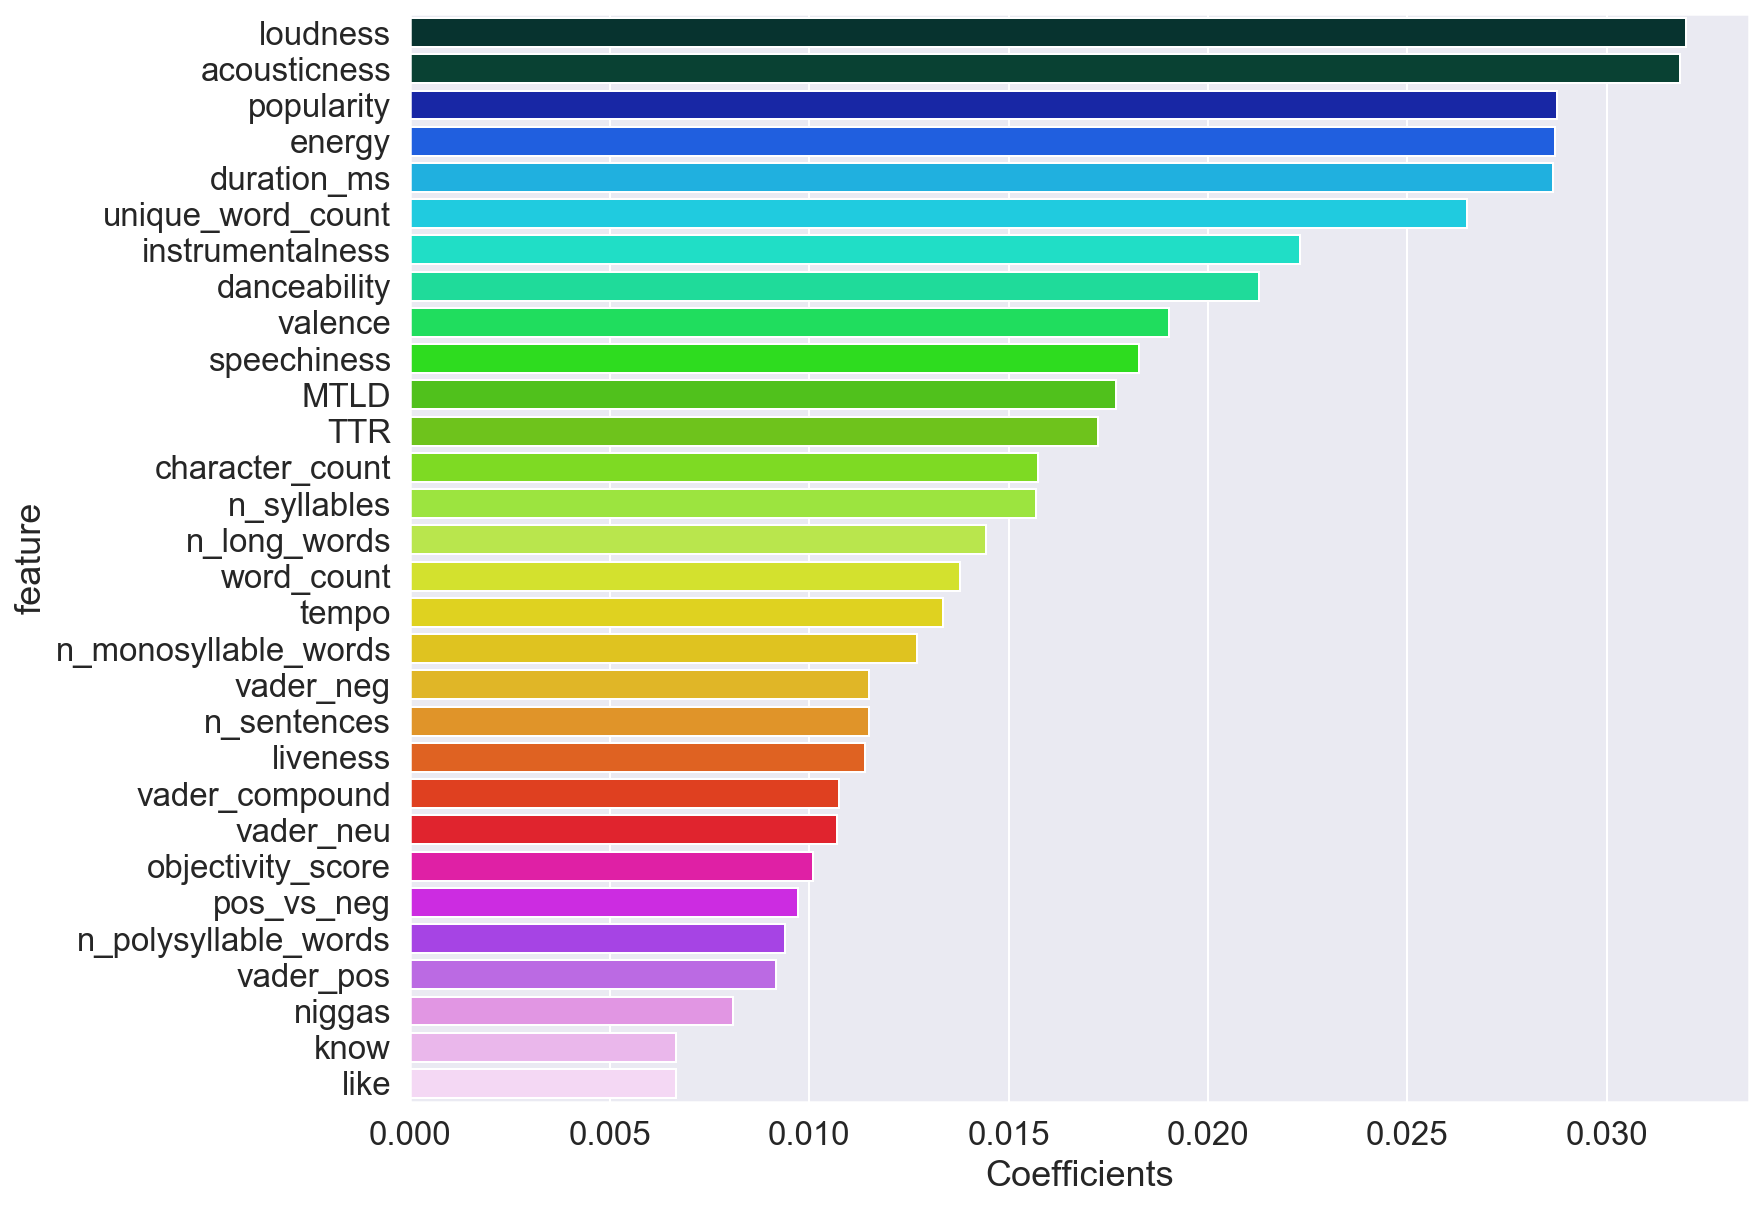

In [75]:
fig, ax = plt.subplots(figsize=(12,10))
sns.barplot(data=feature_sorted, y='feature', x='importance', orient='h', palette='gist_ncar')
ax.set(xlabel='Coefficients')
ax.set_yticklabels(labels=feature_sorted.feature);

## Increased Dataset to 1615 Total Rows

This dataset has a **baseline** of 0.0724.

In [76]:
complete = pd.read_csv('/Users/constancemaurer/GA DSI 12/DSI12-lessons/projects/project-capstone/part-04/Big_model_data.csv')
big_train = pd.read_csv('/Users/constancemaurer/GA DSI 12/DSI12-lessons/projects/project-capstone/part-04/big_train_set.csv')
big_test = pd.read_csv('/Users/constancemaurer/GA DSI 12/DSI12-lessons/projects/project-capstone/part-04/big_test_set.csv')

In [77]:
y_train = big_train.pop('artist_name')
X_train = big_train.copy()

In [78]:
y_test = big_test.pop('artist_name')
X_test = big_test.copy()

In [79]:
X_train = dummyifying(X_train, ['key', 'time_signature','mode'])
X_test = dummyifying(X_test, ['key', 'time_signature','mode'])

In [80]:
X_train_t, y_train_t, X_test_t, y_test_t = tvec_processing('lyrics_processed', X_train, y_train, X_test, y_test)

In [81]:
X_train_t.drop('lyrics_processed', axis=1, inplace=True)
X_test_t.drop('lyrics_processed', axis=1, inplace=True)

In [82]:
X_train_t, X_test_t = StandardScaler_processing(X_train_t, X_test_t)

### Random Forest Summariaed Optimisation

In [83]:
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=40, max_features=150, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [84]:
rf.fit(X_train_t, y_train_t)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=40, max_features=150, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [85]:
feature_import = pd.DataFrame({'feature': np.array(X_train_t.columns), 'importance':rf.feature_importances_})

**Reducing features to 200 most important ones:**

In [86]:
features_list = []
for i in feature_import.sort_values('importance', ascending=False)[:200].feature:
    features_list.append(i)

In [87]:
cross_val_score(rf, X_train_t, y_train_t, cv=5).mean()

0.4798750821711539

In [88]:
X_train_reduced = X_train_t[features_list]

In [89]:
X_test_reduced = X_test_t[features_list]

In [90]:
random_forest = RandomForestClassifier(random_state=42)

In [91]:
params = {'class_weight':['balanced'],
         'n_estimators':[500],
         'criterion': ['gini'],
         'max_depth': [None, 25, 50, 75],
         'max_features': [None, 50, 90 ,100, 120, 150]}

In [92]:
random_grid = GridSearchCV(random_forest,
                           param_grid=params,
                           scoring='accuracy'
                           cv=5,
                           n_jobs=2,
                           verbose=1,
                           iid=False)
random_grid.fit(X_train_reduced, y_train_t)
random_grid.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  6.2min
[Parallel(n_jobs=2)]: Done 120 out of 120 | elapsed: 16.3min finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=25, max_features=120,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [93]:
random_grid.best_score_

0.507995973755083

In [94]:
best_rand = random_grid.best_estimator_

In [95]:
print('Cross validation score:')
print(cross_val_score(best_rand, X_train_reduced, y_train_t, cv=5, scoring='accuracy').mean())
print('Training accuracy score:')
print(best_rand.score(X_train_reduced, y_train_t))
print('Testing accuracy score:')
print(best_rand.score(X_test_reduced, y_test_t))

Cross validation score:
0.507995973755083
Training accuracy score:
1.0
Testing accuracy score:
0.5139318885448917


### Evaluation

In [96]:
predict_train = best_rand.predict(X_train_reduced)
predict_test = best_rand.predict(X_test_reduced)

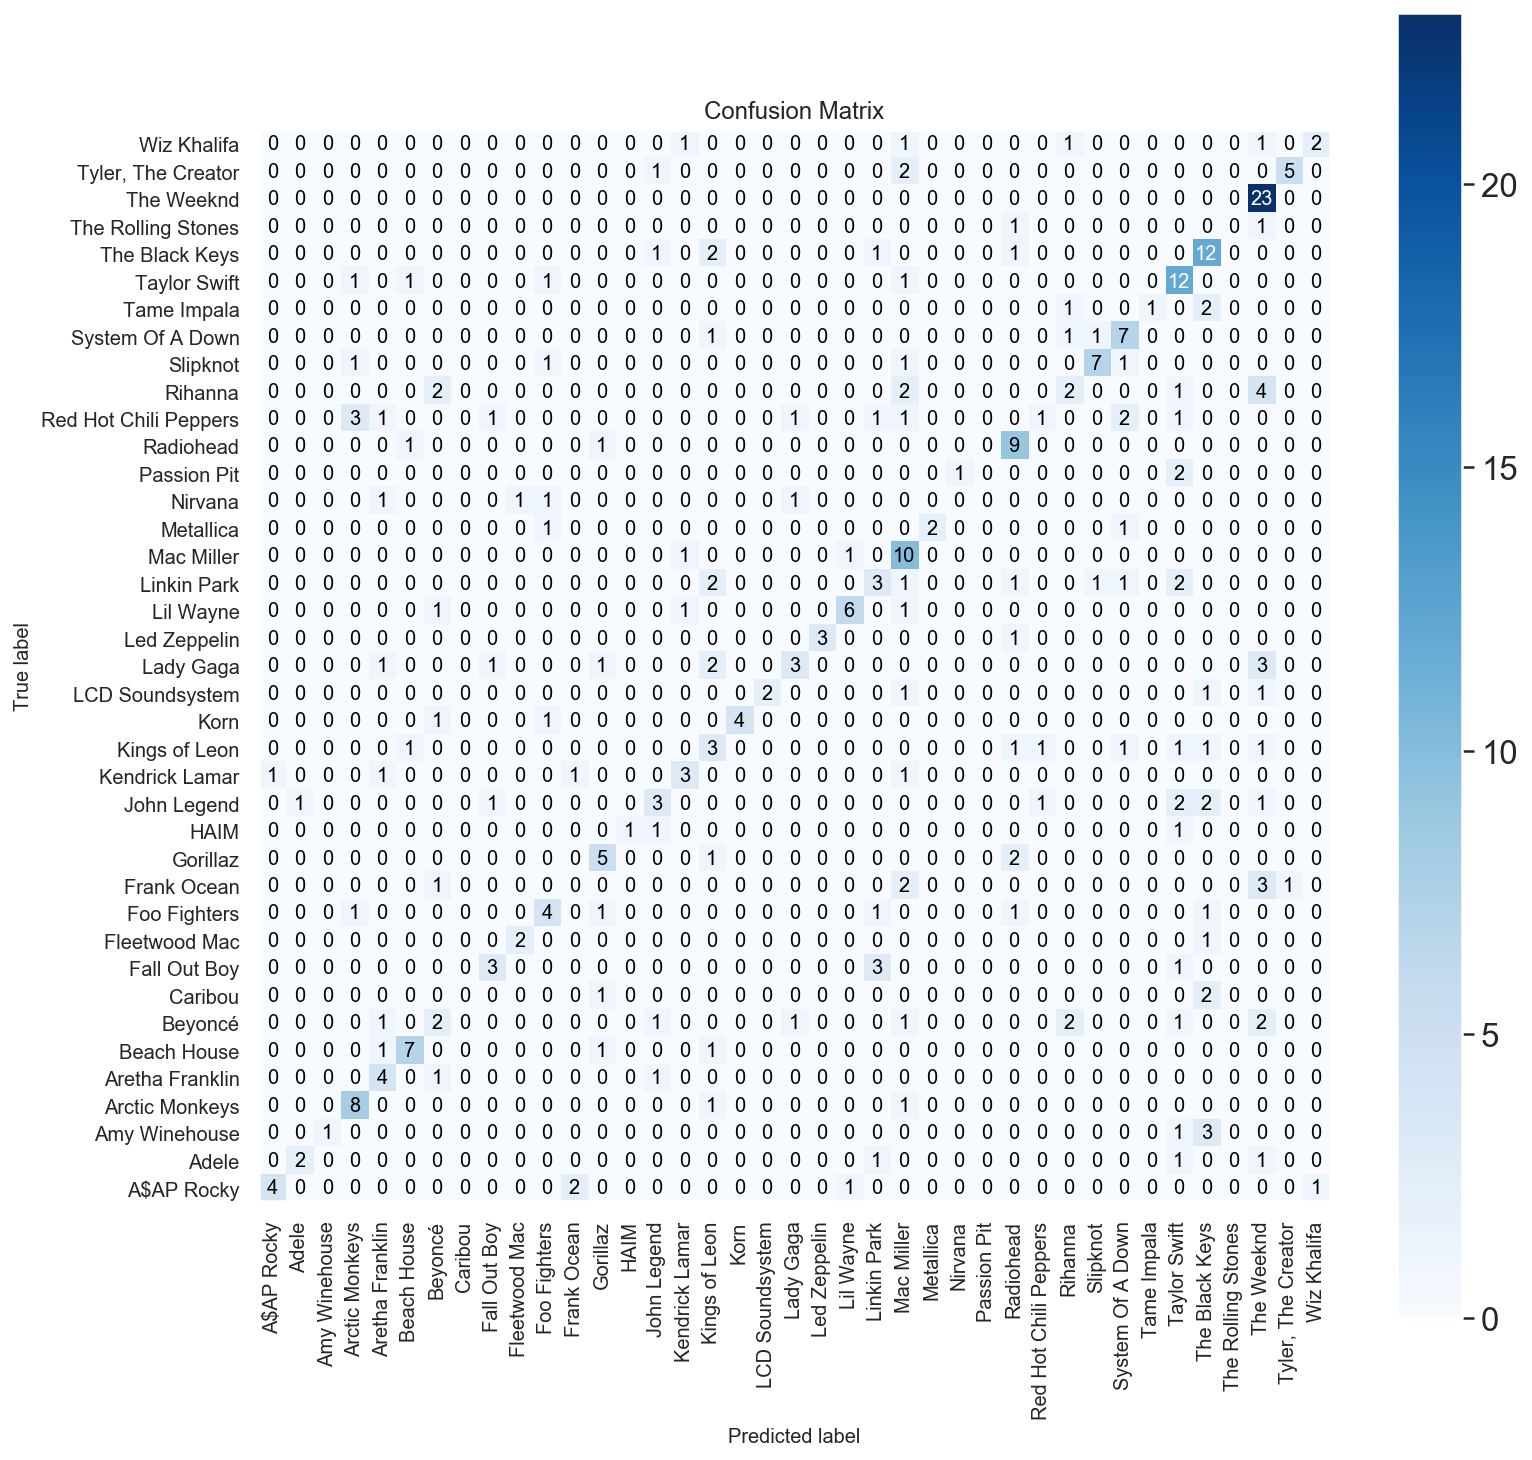

In [97]:
cmap = ListedColormap(sns.color_palette("husl", len(best_rand.classes_)))
skplt.metrics.plot_confusion_matrix(y_test_t, predict_test, figsize=(12,12))
plt.ylim([-0.5, len(y_train_t.unique())-0.5])
plt.xticks(rotation=90)
plt.show()

In [98]:
print(classification_report(y_test_t, predict_test))

                       precision    recall  f1-score   support

           A$AP Rocky       0.80      0.50      0.62         8
                Adele       0.67      0.40      0.50         5
        Amy Winehouse       1.00      0.20      0.33         5
       Arctic Monkeys       0.57      0.80      0.67        10
      Aretha Franklin       0.40      0.67      0.50         6
          Beach House       0.70      0.70      0.70        10
              Beyoncé       0.25      0.18      0.21        11
              Caribou       0.00      0.00      0.00         3
         Fall Out Boy       0.50      0.43      0.46         7
        Fleetwood Mac       0.67      0.67      0.67         3
         Foo Fighters       0.44      0.44      0.44         9
          Frank Ocean       0.00      0.00      0.00         7
             Gorillaz       0.50      0.62      0.56         8
                 HAIM       1.00      0.33      0.50         3
          John Legend       0.38      0.27      0.32  

In [99]:
classification_report_table = complete.groupby('artist_name').count()[['track_name']]
classification_report_table.reset_index(inplace=True)

In [100]:
precision, recall, f1, support = precision_recall_fscore_support(y_test_t, predict_test, average=None)

In [101]:
classification_report_table['precision_score'] = precision
classification_report_table['recall_score'] = recall
classification_report_table['f1_score'] = f1
classification_report_table['n_samples_test_set'] = support
classification_report_table

artist_name  track_name  precision_score  recall_score  \
0              A$AP Rocky          41         0.800000      0.500000   
1                   Adele          24         0.666667      0.400000   
2           Amy Winehouse          25         1.000000      0.200000   
3          Arctic Monkeys          48         0.571429      0.800000   
4         Aretha Franklin          31         0.400000      0.666667   
5             Beach House          50         0.700000      0.700000   
6                 Beyoncé          57         0.250000      0.181818   
7                 Caribou          13         0.000000      0.000000   
8            Fall Out Boy          33         0.500000      0.428571   
9           Fleetwood Mac          13         0.666667      0.666667   
10           Foo Fighters          47         0.444444      0.444444   
11            Frank Ocean          37         0.000000      0.000000   
12               Gorillaz          40         0.500000      0.625000   
13                   HAIM          14         1.000000      0.333333   
14            John Legend          54         0.375000      0.272727   
15         Kendrick Lamar          37         0.500000      0.428571   
16          Kings of Leon          49         0.230769      0.300000   
17                   Korn          31         1.000000      0.666667   
18        LCD Soundsystem          25         1.000000      0.400000   
19              Lady Gaga          53         0.500000      0.272727   
20           Led Zeppelin          18         1.000000      0.750000   
21              Lil Wayne          46         0.750000      0.666667   
22            Linkin Park          57         0.300000      0.272727   
23             Mac Miller          60         0.384615      0.833333   
24              Metallica          19         1.000000      0.500000   
25                Nirvana          22         0.000000      0.000000   
26            Passion Pit          17         0.000000      0.000000   
27              Radiohead          54         0.529412      0.818182   
28  Red Hot Chili Peppers          58         0.333333      0.083333   
29                Rihanna          53         0.285714      0.181818   
30               Slipknot          54         0.777778      0.636364   
31       System Of A Down          51         0.538462      0.700000   
32            Tame Impala          20         1.000000      0.250000   
33           Taylor Swift          82         0.461538      0.750000   
34         The Black Keys          86         0.480000      0.705882   
35     The Rolling Stones          10         0.000000      0.000000   
36             The Weeknd         117         0.560976      1.000000   
37     Tyler, The Creator          40         0.833333      0.625000   
38            Wiz Khalifa          29         0.666667      0.333333   

    f1_score  n_samples_test_set  
0   0.615385                   8  
1   0.500000                   5  
2   0.333333                   5  
3   0.666667                  10  
4   0.500000                   6  
5   0.700000                  10  
6   0.210526                  11  
7   0.000000                   3  
8   0.461538                   7  
9   0.666667                   3  
10  0.444444                   9  
11  0.000000                   7  
12  0.555556                   8  
13  0.500000                   3  
14  0.315789                  11  
15  0.461538                   7  
16  0.260870                  10  
17  0.800000                   6  
18  0.571429                   5  
19  0.352941                  11  
20  0.857143                   4  
21  0.705882                   9  
22  0.285714                  11  
23  0.526316                  12  
24  0.666667                   4  
25  0.000000                   4  
26  0.000000                   3  
27  0.642857                  11  
28  0.133333                  12  
29  0.222222                  11  
30  0.700000                  11  
31  0.608696 

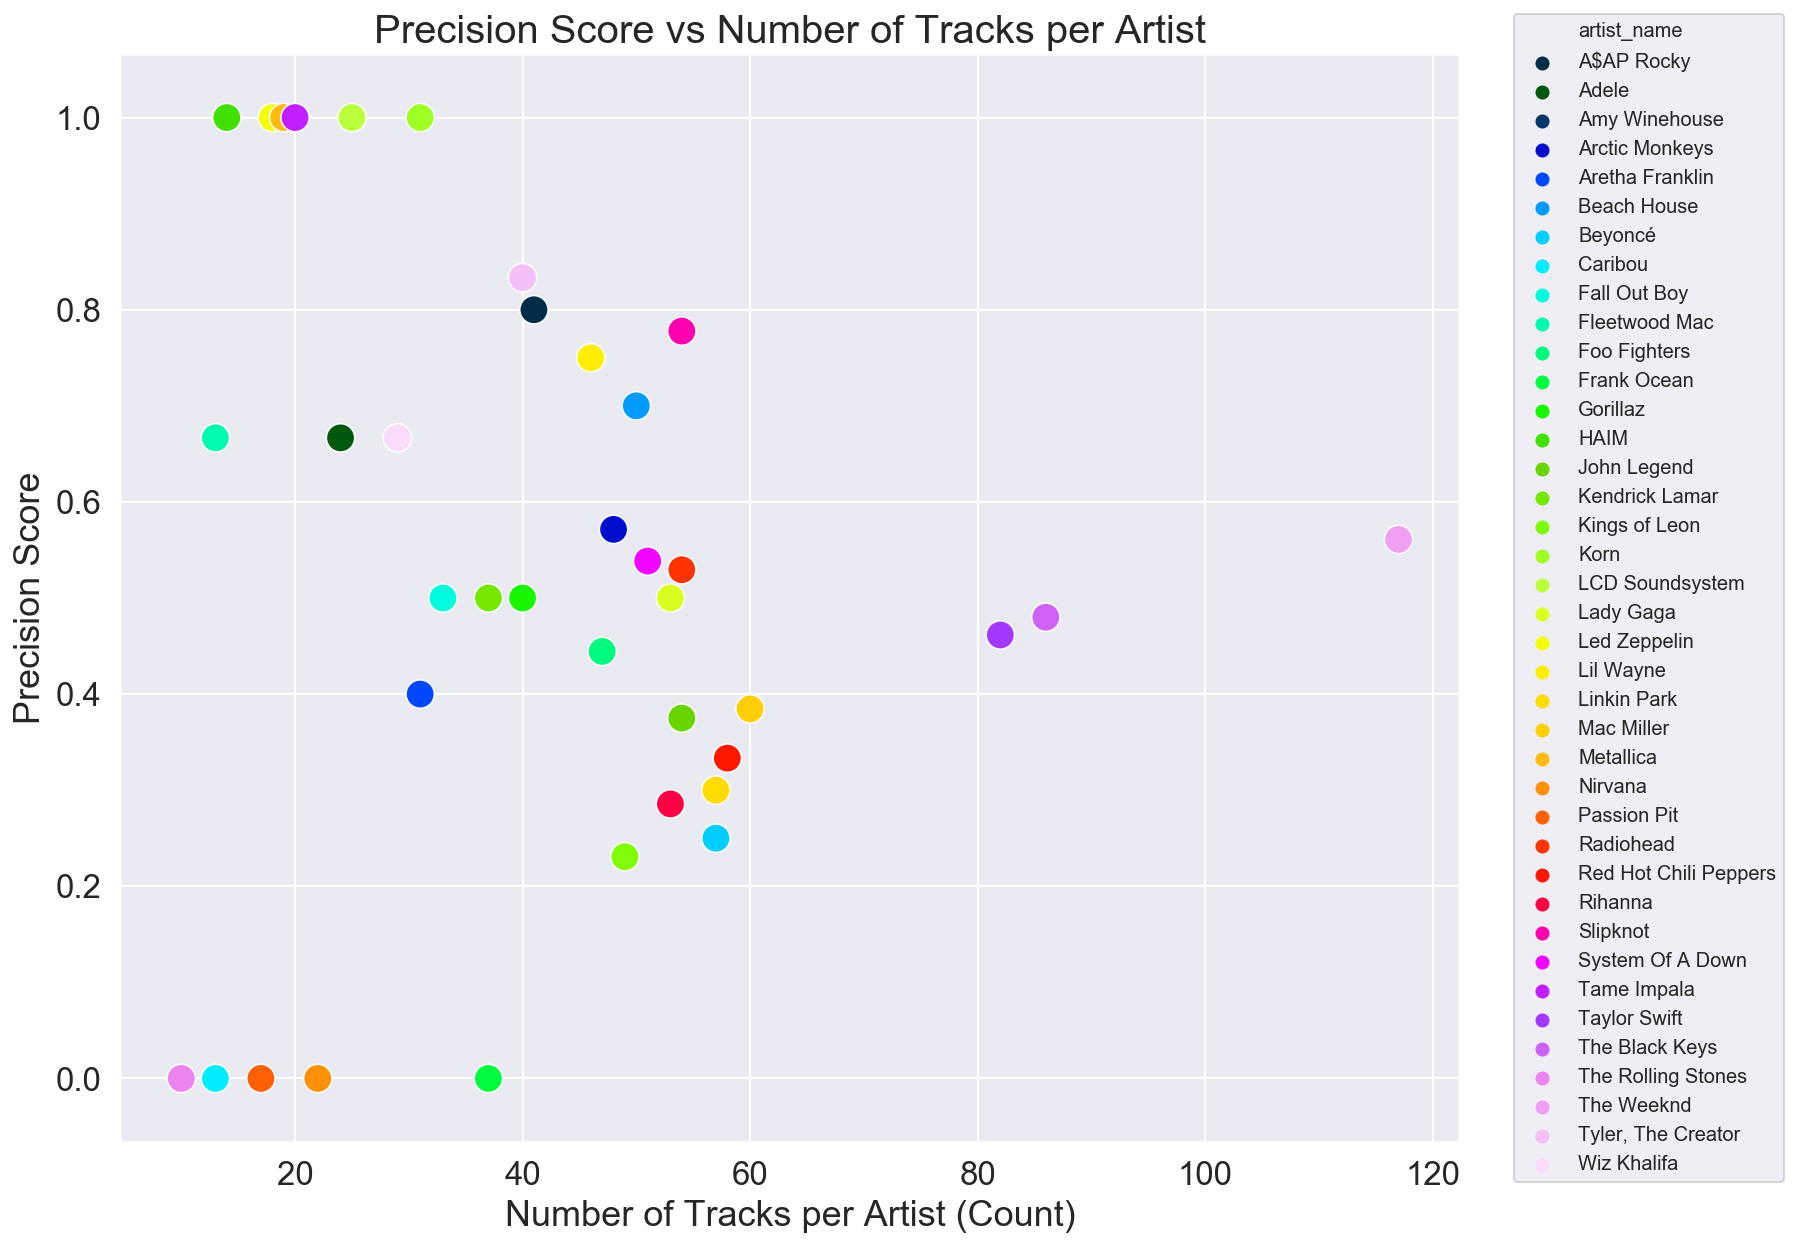

In [102]:
fig, ax = plt.subplots(figsize=(12,10))
sns.scatterplot(data=classification_report_table, x='track_name', y='precision_score', hue='artist_name', s=200, palette='gist_ncar');
#sns.scatterplot(data=artist_count, x='track_name', y='recall_score', hue='artist_name', palette='Blues');
#sns.scatterplot(data=artist_count, x='track_name', y='f1_score', hue='artist_name', palette='Greens');
ax.set_xlabel('Number of Tracks per Artist (Count)');
ax.set_ylabel('Precision Score');
plt.title("Precision Score vs Number of Tracks per Artist", size=20)
ax.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1, fontsize='medium')
plt.show()

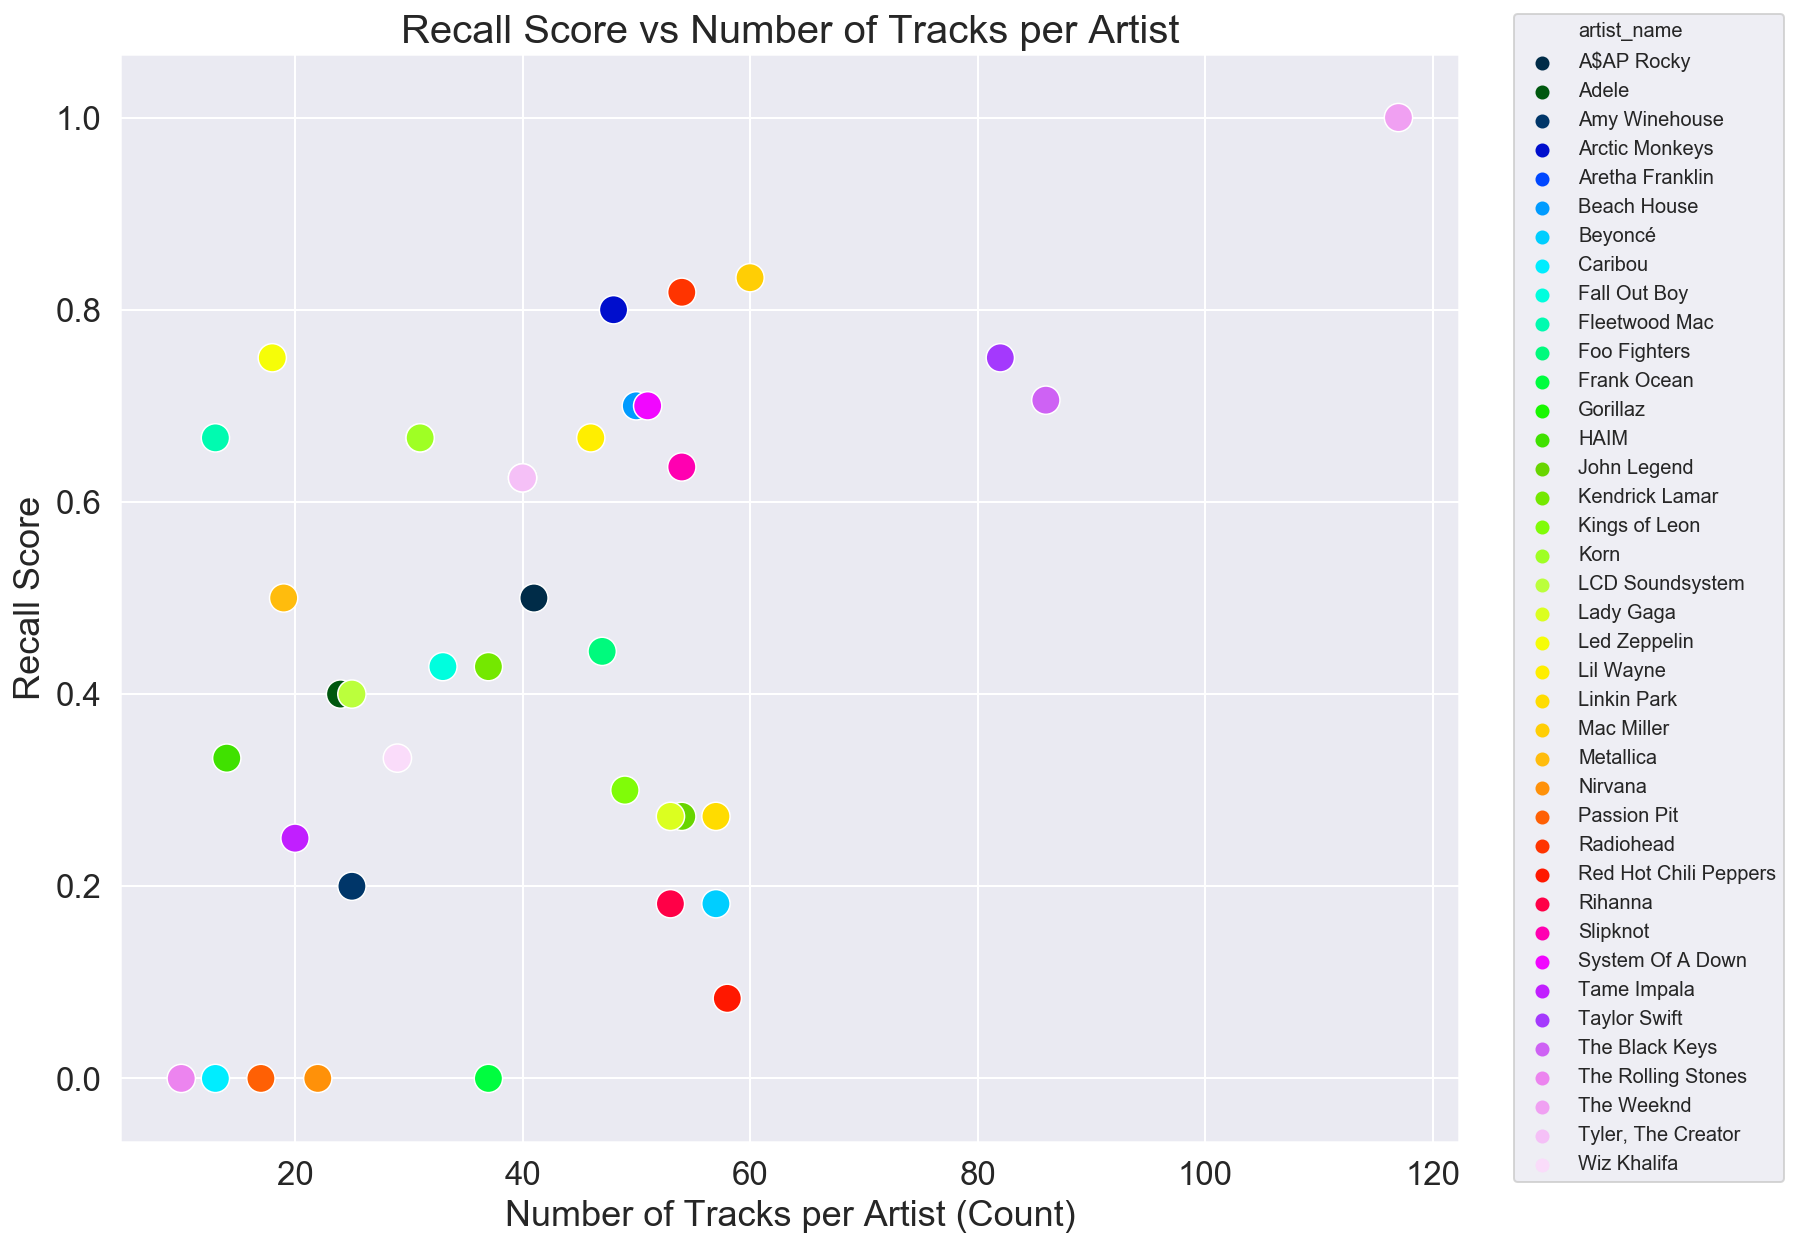

In [103]:
fig, ax = plt.subplots(figsize=(12,10))
#sns.scatterplot(data=artist_count, x='track_name', y='precision_score', hue='artist_name', palette='Reds');
sns.scatterplot(data=classification_report_table, x='track_name', y='recall_score', hue='artist_name', s=200, palette='gist_ncar');
#sns.scatterplot(data=artist_count, x='track_name', y='f1_score', hue='artist_name', palette='Greens');
ax.set_xlabel('Number of Tracks per Artist (Count)');
ax.set_ylabel('Recall Score');
plt.title("Recall Score vs Number of Tracks per Artist", size=20)
ax.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1, fontsize='medium')
plt.show()

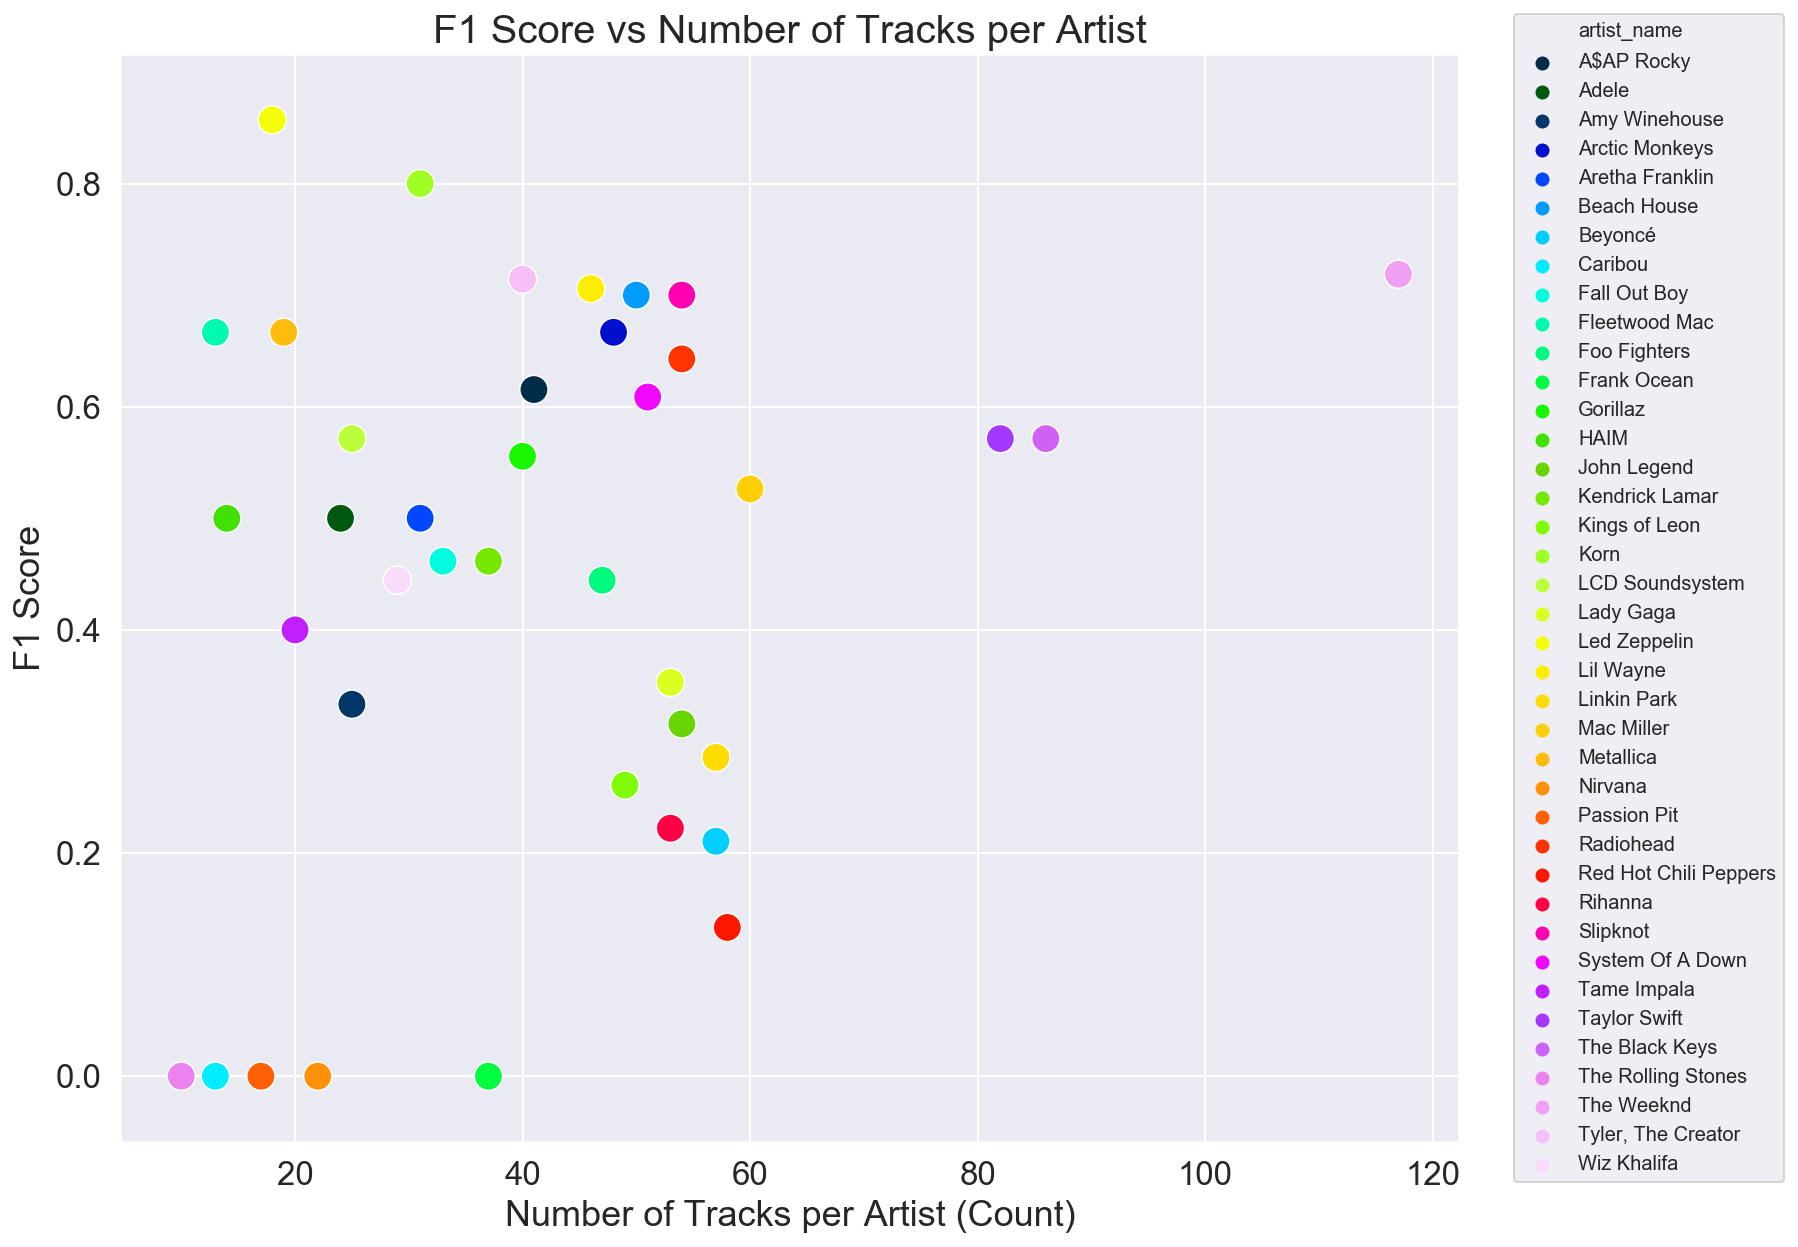

In [104]:
fig, ax = plt.subplots(figsize=(12,10))
#sns.scatterplot(data=classification_report_table, x='track_name', y='precision_score', hue='artist_name', palette='Reds');
#sns.scatterplot(data=classification_report_table, x='track_name', y='recall_score', hue='artist_name', palette='gist_ncar');
sns.scatterplot(data=classification_report_table, x='track_name', y='f1_score', hue='artist_name', s=200, palette='gist_ncar');
ax.set_xlabel('Number of Tracks per Artist (Count)');
ax.set_ylabel('F1 Score');
plt.title("F1 Score vs Number of Tracks per Artist", size=20)
ax.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1, fontsize='medium')
plt.show()

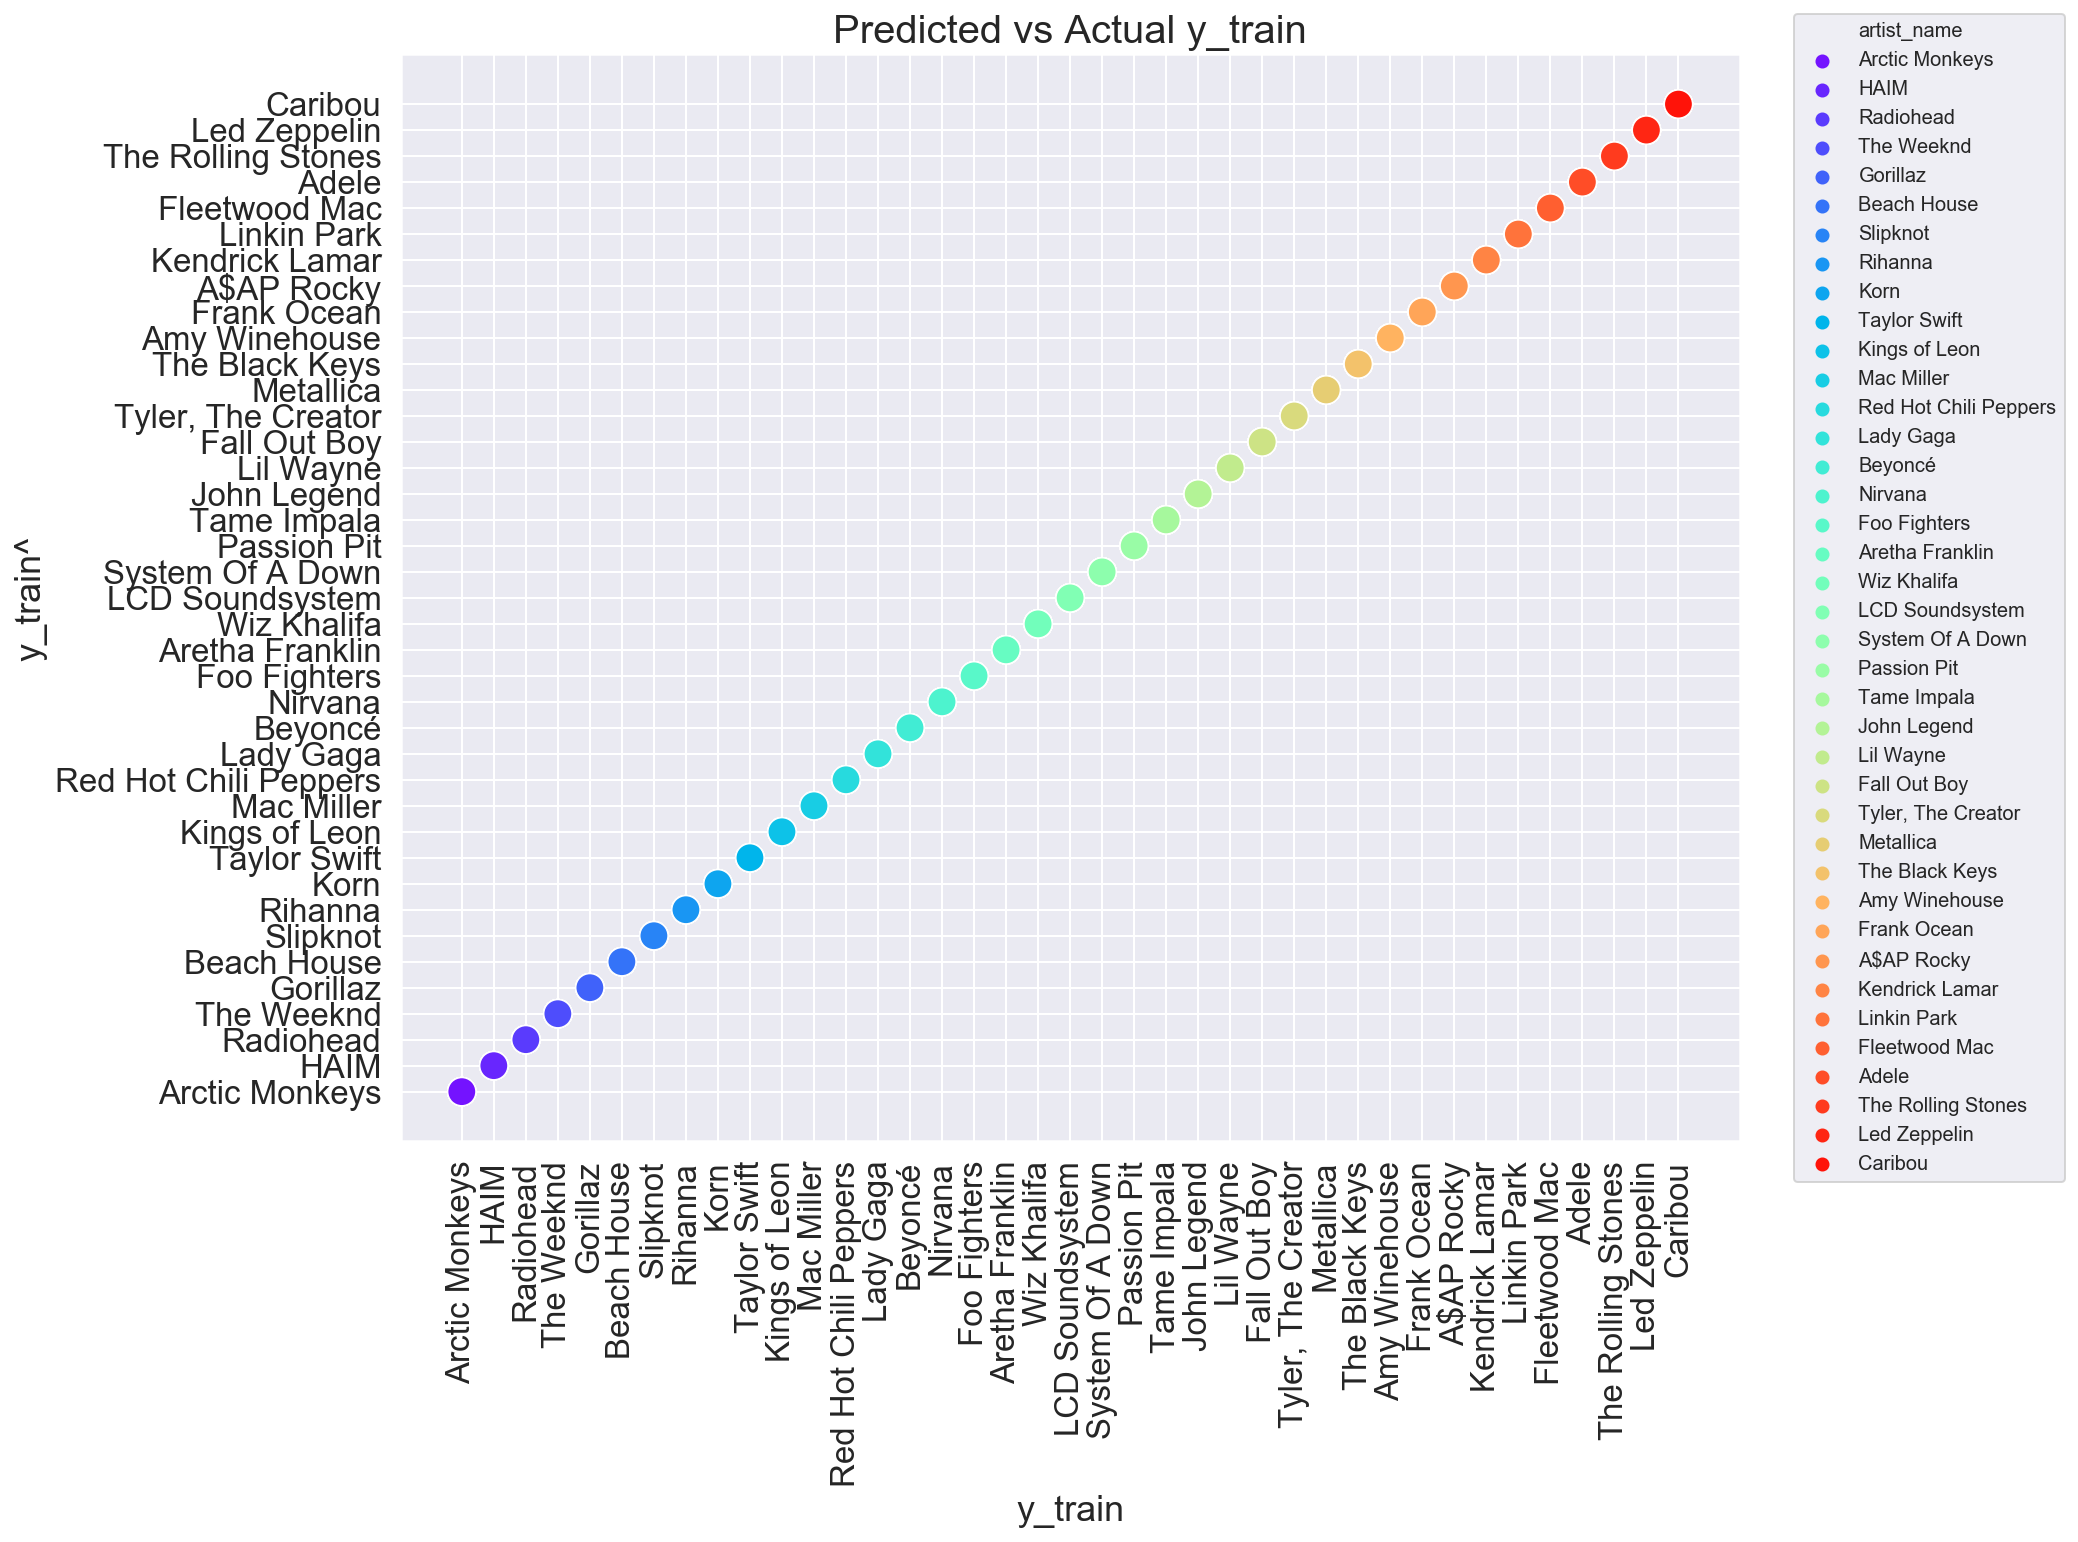

In [105]:
fig, ax = plt.subplots(figsize=(12,10))
sns.scatterplot(x=y_train_t, y=predict_train, hue=y_train_t, s=200, palette='rainbow');
ax.set_xlabel('y_train');
ax.set_xticklabels(labels=y_train_t.unique(), rotation=90)
ax.set_ylabel('y_train^');
plt.title("Predicted vs Actual y_train", size=20)
ax.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1, fontsize='medium')
plt.show()

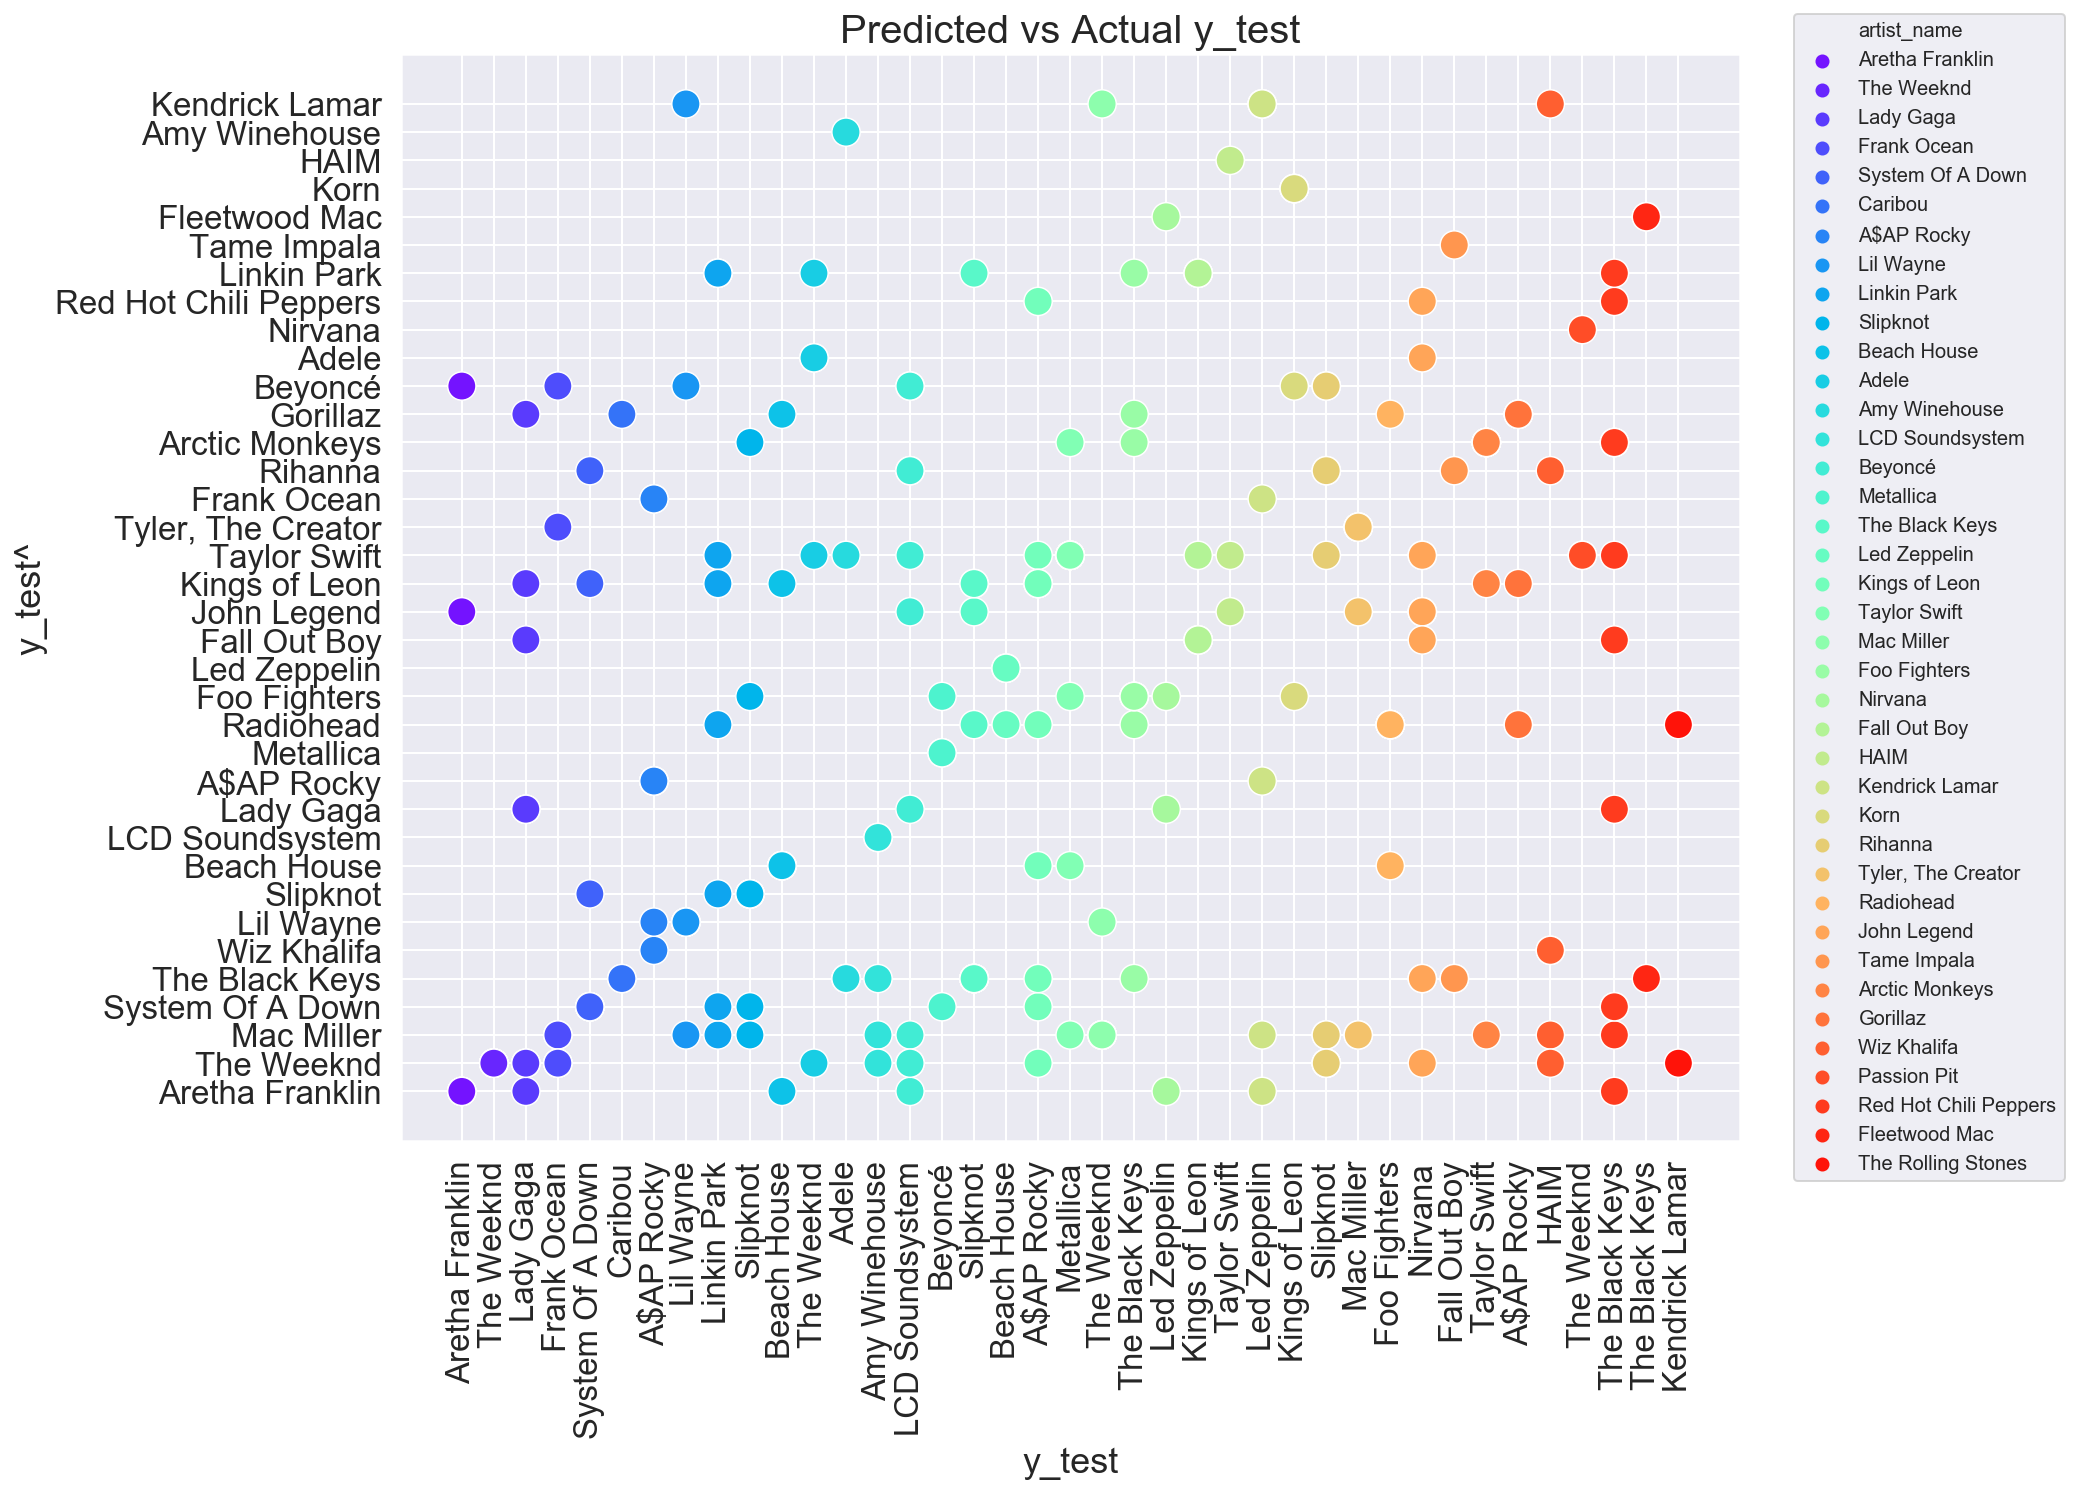

In [106]:
fig, ax = plt.subplots(figsize=(12,10))
sns.scatterplot(x=y_test_t, y=predict_test, hue=y_test_t, s=200, palette='rainbow');
ax.set_xlabel('y_test');
ax.set_xticklabels(labels=y_test_t, rotation=90)
#ax.set_yticklabels(labels=predict_test, rotation=0);
ax.set_ylabel('y_test^');
plt.title("Predicted vs Actual y_test", size=20)
ax.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1, fontsize='medium')
plt.show()

* Computed ROC Curve by binarizing the classes with the label_binarize( ) function. This is neccessary for multi-label classification.

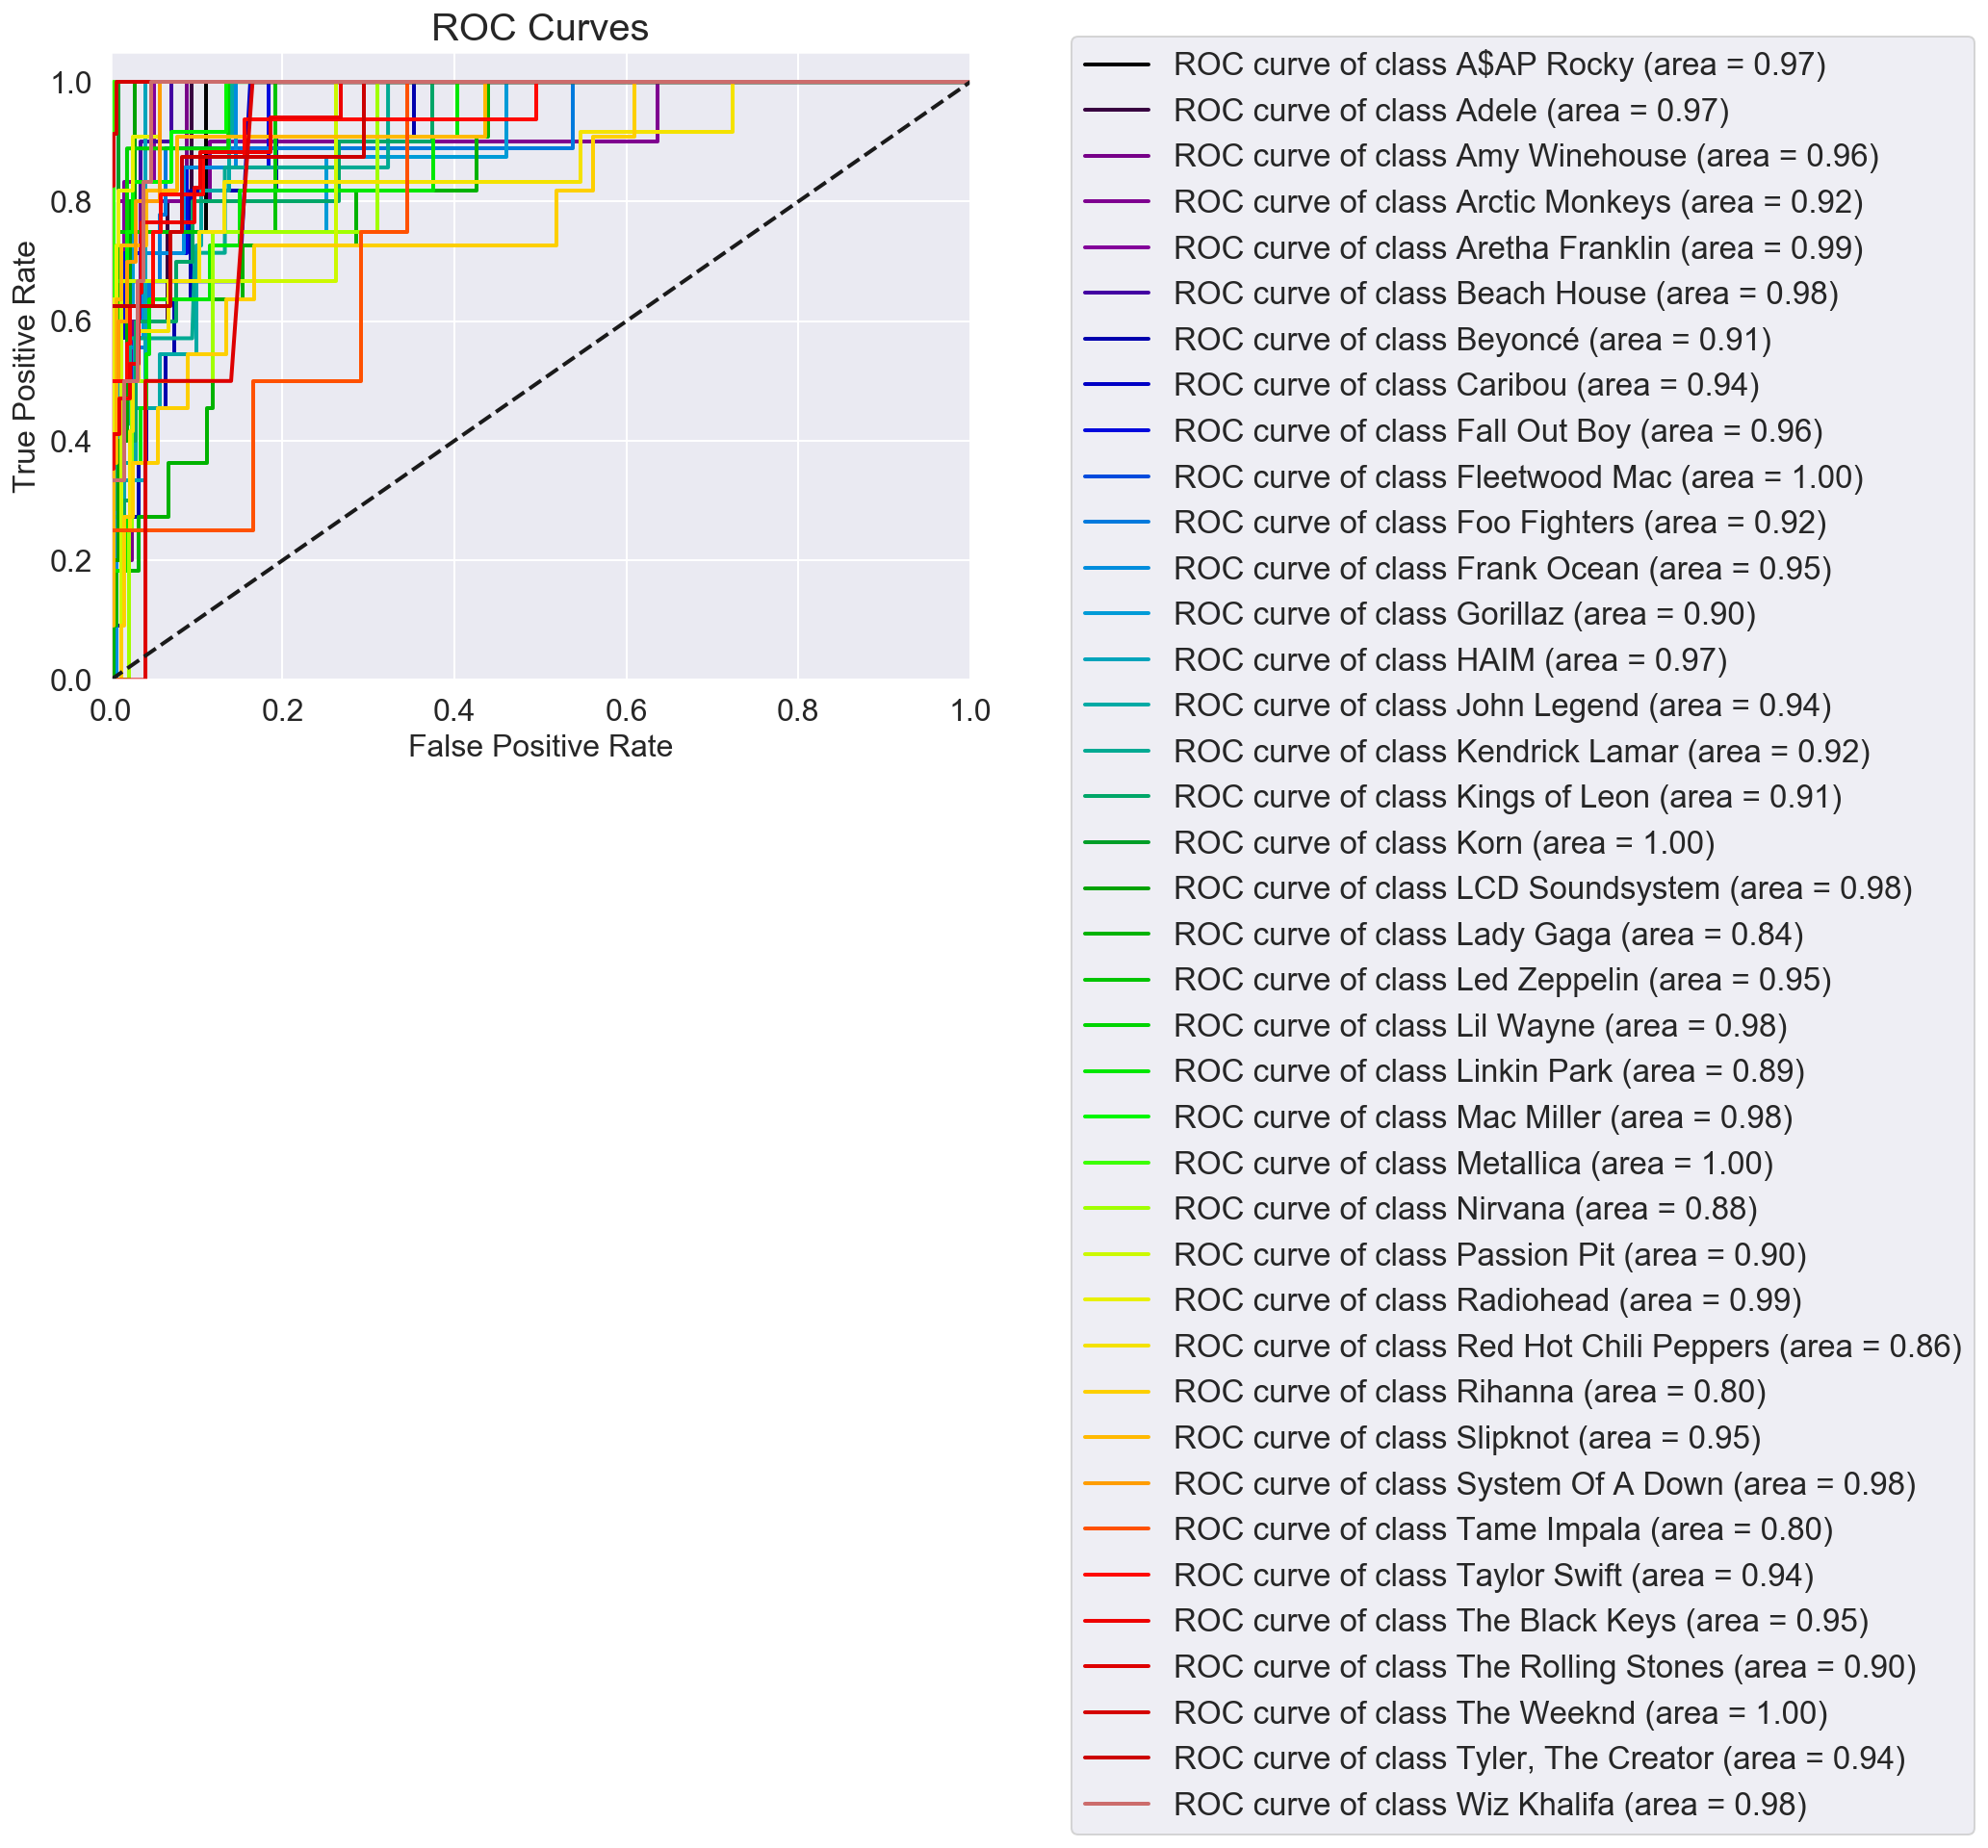

Area under ROC curve (ROC-AUC):
Class A$AP Rocky: 0.97
Class Adele: 0.97
Class Amy Winehouse: 0.96
Class Arctic Monkeys: 0.92
Class Aretha Franklin: 0.99
Class Beach House: 0.98
Class Beyoncé: 0.91
Class Caribou: 0.94
Class Fall Out Boy: 0.96
Class Fleetwood Mac: 1.0
Class Foo Fighters: 0.92
Class Frank Ocean: 0.95
Class Gorillaz: 0.9
Class HAIM: 0.97
Class John Legend: 0.94
Class Kendrick Lamar: 0.92
Class Kings of Leon: 0.91
Class Korn: 1.0
Class LCD Soundsystem: 0.98
Class Lady Gaga: 0.84
Class Led Zeppelin: 0.95
Class Lil Wayne: 0.98
Class Linkin Park: 0.89
Class Mac Miller: 0.98
Class Metallica: 1.0
Class Nirvana: 0.88
Class Passion Pit: 0.9
Class Radiohead: 0.99
Class Red Hot Chili Peppers: 0.86
Class Rihanna: 0.8
Class Slipknot: 0.95
Class System Of A Down: 0.98
Class Tame Impala: 0.8
Class Taylor Swift: 0.94
Class The Black Keys: 0.95
Class The Rolling Stones: 0.9
Class The Weeknd: 1.0
Class Tyler, The Creator: 0.94
Class Wiz Khalifa: 0.98


In [107]:
y_test_bin = label_binarize(y_test_t, best_rand.classes_)

skplt.metrics.plot_roc(y_test_t,
                       best_rand.predict_proba(X_test_reduced),
                       plot_micro=False,
                       plot_macro=False,
                       title_fontsize=20,
                       text_fontsize=16,
                       figsize=(8, 6))

plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

print('Area under ROC curve (ROC-AUC):')
for i, class_ in enumerate(best_rand.classes_):
    print(
        'Class {}:'.format(class_),
        round(
            roc_auc_score(y_test_bin[:, i],
                          best_rand.predict_proba(X_test_reduced)[:, i]), 2))

* Produced CSV file of actual and predicted test data for further use in visualisations such as neural networks.

In [108]:
test_df = pd.DataFrame({'y_test': y_test_t, 'y_test_predicted': predict_test})
test_df.to_csv('test_targets_predictions.csv', index=False)

In [109]:
test_df.head()

y_test  y_test_predicted
0   Aretha Franklin   Aretha Franklin
1        The Weeknd        The Weeknd
2         Lady Gaga   Aretha Franklin
3       Frank Ocean        Mac Miller
4  System Of A Down  System Of A Down

* Determined feature importance of this optimised model. Among the highest predictors are popularity, loudness, acousticness, unique_word_count, duration_ms and energy. 

In [110]:
feature_import = pd.DataFrame({'feature': np.array(X_train_reduced.columns), 'importance':best_rand.feature_importances_})
feature_import.head()

feature  importance
0             energy    0.032348
1       acousticness    0.040896
2           loudness    0.044193
3         popularity    0.048432
4  unique_word_count    0.035702

In [111]:
feature_sorted = feature_import.sort_values('importance', ascending=False)[:30]

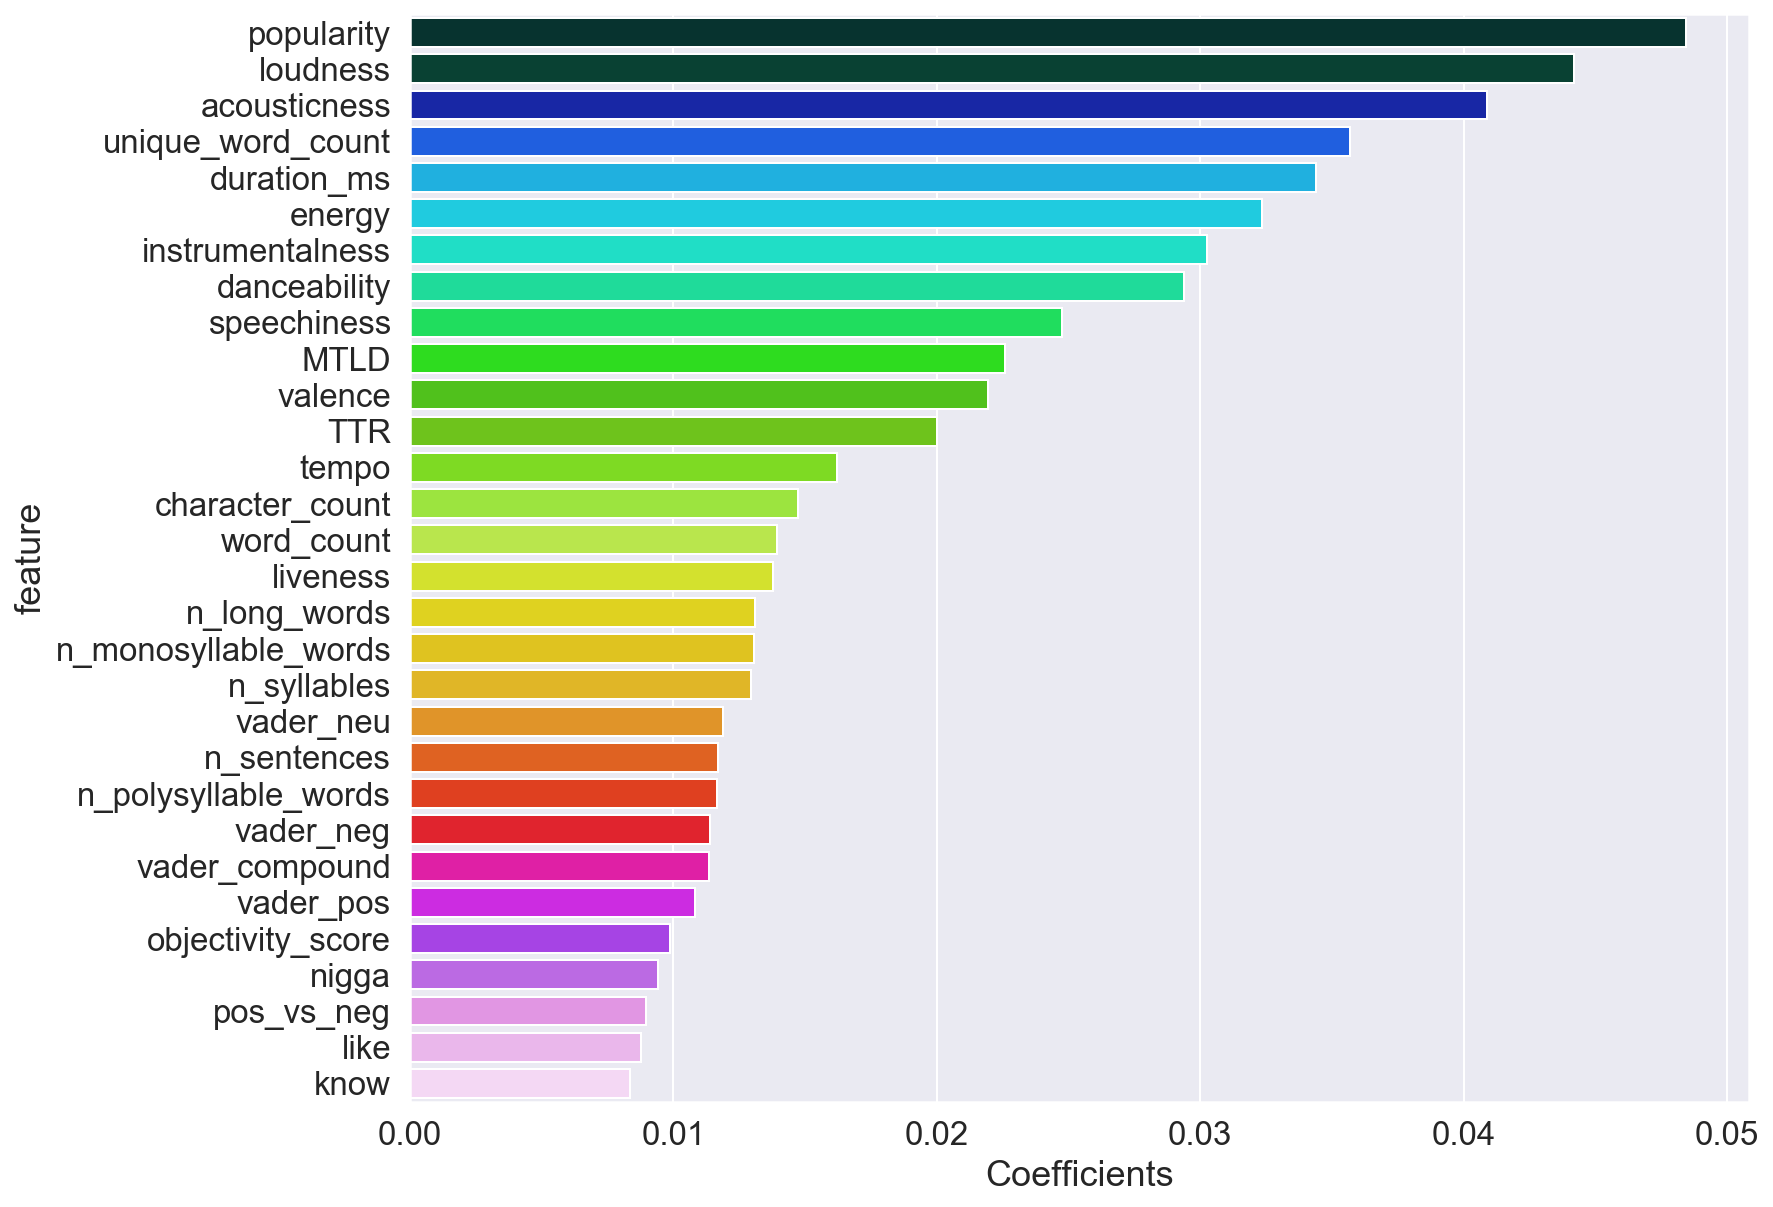

In [112]:
fig, ax = plt.subplots(figsize=(12,10))
sns.barplot(data=feature_sorted, y='feature', x='importance', orient='h', palette='gist_ncar')
ax.set(xlabel='Coefficients')
ax.set_yticklabels(labels=feature_sorted.feature);

## Summary

**Model based on 1312 rows dataset:**
* Random forest optimisation was able to increase the cross-validation score from 0.433 to **0.459** within the same dataset (baseline=0.058) by simply implementing balanced class weights and reducing the predictors/features to the 500 most important ones.


* Features which had the highest coefficients/were able to influence the predictions the strongest were loudness, acousticness, popularity, energy, duration_ms and unique_word_count.


* Precision and recall scores were 43% and 39%, respectively, indicating that the model possesses more false negatives than false positives.


* Plotting the precision, recall and F1 scores vs the count of songs per artists, showed that the majority class had higher true positive results than classes with a lower representation.


**Model based on 1615 rows dataset:**
* When increasing the total rows of the data from 1312 to 1615 rows (baseline=0.072) and applying the same optimisation steps (balancing class weights and reducing the features to the top 200), the cross-validation score was able to improve to **0.508**. 


* Feature importance favoured popularity, loudness, acousticness, unique_word_count, duration_ms and energy. It increase the importance of popularity and unique_word_count for example. 
* It is interesting to note that the order of type of features that influence the class prediction seems to be music features, lexical diversity, text statistics, sentiment and then frequency of specific words.


* Enriching the dataset increased the precision and recall scores to 54% and 55%, respectively. The model is now able to have more complete results (less false negatives - indicated by the increased recall score).


* As in the 1312 data model, the highly represented class have higher precision, recall and F! scores more often than classes with a lower representation.


* Factors increasing the predictability are number of entries per class, uniqueness in music style, the sentiment of the lyrics and lastly the content of words in the lyrics.